In [75]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline 
import math
from sklearn.model_selection import train_test_split
from scipy.optimize import brute
import time
from sklearn.model_selection import RandomizedSearchCV
from functools import partial
import swifter
from tqdm import tqdm

In [54]:

df=pd.read_csv('final.csv', sep=',')

In [55]:
df.head()

,user_id,tag_code,is_right
0,29110,c050101,"[0, 0, 1, 0, 1]"
1,29110,c050102,"[1, 0, 0, 1, 1]"
2,29110,c050103,"[1, 0, 0, 0, 1]"
3,29110,c050104,"[0, 0, 1, 1, 1]"
4,29110,c050201,"[1, 0, 1, 0, 1]"


In [56]:
df.shape
# a = df.is_right.head()
# type(a[0])

(83563, 3)

In [57]:
# 不需要这个进行转换
def map_li(x):
    x = x.lstrip('[').rstrip(']').split(', ')
    return list(map(int, x))

In [58]:
df['is_right'] = df['is_right'].map(lambda x: map_li(x))

In [59]:
df.head()
# a = df.is_right.head()
# type(a[0])


,user_id,tag_code,is_right
0,29110,c050101,"[0, 0, 1, 0, 1]"
1,29110,c050102,"[1, 0, 0, 1, 1]"
2,29110,c050103,"[1, 0, 0, 0, 1]"
3,29110,c050104,"[0, 0, 1, 1, 1]"
4,29110,c050201,"[1, 0, 1, 0, 1]"


In [60]:
train, test =  train_test_split(df, test_size=0.2)
train.shape, test.shape

((66850, 3), (16713, 3))

In [61]:
# df1 做题数目>2的知识点
df['length'] = df['is_right'].map(lambda x: len(x))
df1=df.loc[df.length>2, ][['user_id', 'tag_code', 'is_right', 'length']]

In [62]:
df1.head()

,user_id,tag_code,is_right,length
0,29110,c050101,"[0, 0, 1, 0, 1]",5
1,29110,c050102,"[1, 0, 0, 1, 1]",5
2,29110,c050103,"[1, 0, 0, 0, 1]",5
3,29110,c050104,"[0, 0, 1, 1, 1]",5
4,29110,c050201,"[1, 0, 1, 0, 1]",5


In [63]:
df1.shape

(81598, 4)

(array([1.8210e+04, 0.0000e+00, 2.2647e+04, 0.0000e+00, 2.0220e+04,
        0.0000e+00, 2.0462e+04, 0.0000e+00, 5.3000e+01, 6.0000e+00]),
 array([3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ]),
 <a list of 10 Patch objects>)

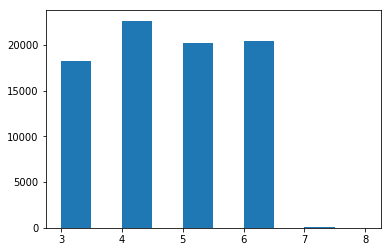

In [64]:
plt.hist(df1.length)
# would the learning problems size have an effect on the data (eg, remove problems < 2)

In [65]:
# check each tag_code and see how many users have learned them. 
gpkc=df1.groupby('tag_code')['user_id'].count().to_frame().reset_index().sort_values('user_id')
gpkc.head()

,tag_code,user_id
826,z120105,8
819,z090102,9
568,c290101,9
260,c140206,10
338,c170312,10


(array([269., 141., 140.,  92.,  59.,  47.,  36.,  19.,  16.,   8.]),
 array([  8. ,  43.8,  79.6, 115.4, 151.2, 187. , 222.8, 258.6, 294.4,
        330.2, 366. ]),
 <a list of 10 Patch objects>)

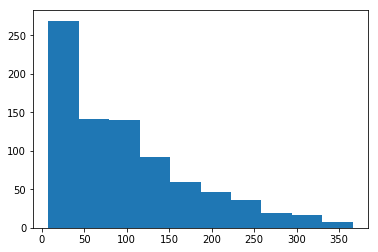

In [66]:
# 统计每个知识点有多少人学。x：某个知识点有多少人学 y：有多少人学的知识点有多少个
plt.hist(gpkc.user_id)

In [67]:
kcs = gpkc[gpkc.user_id>=30].tag_code
kcs.head()

245    c130307
661      q0202
214    c120402
253    c140105
641    c340201
Name: tag_code, dtype: object

In [68]:
# my_df: 统计被30个以上的学生做过的知识点
my_df = pd.DataFrame()

for i in kcs:
    appends = df1[df1['tag_code']==i]
    my_df = pd.concat([my_df, appends], axis = 0)

my_df.shape

(78162, 4)

In [69]:
my_df.head()

,user_id,tag_code,is_right,length
951,30364,c130307,"[1, 1, 1, 1]",4
2536,31712,c130307,"[1, 1, 1]",3
2847,32334,c130307,"[1, 1, 1, 1, 1, 1]",6
4336,34398,c130307,"[0, 0, 0, 1, 0, 0]",6
5521,34878,c130307,"[1, 1, 1, 1]",4


In [103]:
len(my_df.tag_code.unique())

645

In [128]:
def find_ssr(solve, parameters):
    l0, trans, guess, slip = parameters
#     print(trans)
    prevL = l0
    nslip = 1 - slip
    nguess = 1 - guess
    ssr = 0 

    for action in solve: 
#         print('ac',action, 'sol', solve)
        likelihood_correct = prevL * (1.0 - slip) + (1.0 - prevL) * guess
#         print('it ac', action)
        ssr += (action - likelihood_correct) ** 2
        if action:
            postL = (prevL * nslip) / (prevL * nslip + (1.0 - prevL) * guess)
        else:
            postL = prevL * slip / (prevL * slip + (1.0 - prevL) * nguess)
        prevL = postL + (1.0 - postL) * trans
    return ssr  

In [132]:
def ssr(df, parameters):
#     df.loc[:,'ssr']=df['is_right'].map(lambda x: find_ssr(x, parameters))
    df.loc[:,'ssr']=df['is_right'].swifter.apply(lambda x: find_ssr(x, parameters))
#     print(parameters, round(df['ssr'].sum()/df['length'].sum(),8))
#     print(df)
    return round(df['ssr'].sum()/df['length'].sum(),8)

In [135]:
# 不出现警告
pd.options.mode.chained_assignment = None
df1.head()

,user_id,tag_code,is_right,length,ssr
0,29110,c050101,"[0, 0, 1, 0, 1]",5,1.325866
1,29110,c050102,"[1, 0, 0, 1, 1]",5,1.656819
2,29110,c050103,"[1, 0, 0, 0, 1]",5,1.776346
3,29110,c050104,"[0, 0, 1, 1, 1]",5,0.616480
4,29110,c050201,"[1, 0, 1, 0, 1]",5,2.133156


In [138]:
parameters = (0.1, 0.3, 0.1, 0.12)
ssr(df1, parameters)

parameters = (0.7, 0.6, 0.1, 0.12)
ssr(df1, parameters)

       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.325866
1        29110  c050102     [1, 0, 0, 1, 1]       5  1.656819
2        29110  c050103     [1, 0, 0, 0, 1]       5  1.776346
3        29110  c050104     [0, 0, 1, 1, 1]       5  0.616480
4        29110  c050201     [1, 0, 1, 0, 1]       5  2.133156
5        29110  c050202     [1, 0, 0, 0, 1]       5  1.776346
6        29110  c050203     [0, 0, 1, 1, 1]       5  0.616480
7        29110  c050204        [0, 1, 1, 1]       4  0.534551
8        29110  c050205  [0, 0, 0, 1, 1, 0]       6  1.486171
9        29110  c050206  [0, 0, 0, 0, 1, 0]       6  1.428853
10       29110  c050207        [1, 0, 1, 1]       4  1.389032
11       29110  c090101        [0, 1, 1, 0]       4  1.274523
12       29110  c090102  [1, 0, 0, 0, 0, 1]       6  1.918469
13       29110  c090103  [1, 0, 0, 0, 0, 0]       6  1.659606
14       29110  c090201        [1, 1, 0, 1]       4  1.615480
15      

0.24560275

In [140]:
len(my_df.tag_code.unique())

645

In [142]:
# 使用暴力的方法找到全局最小值
def bruteforece_bkt(df, ssr, l0_range, trans_range, guess_range, slip_range, step_size):
        pranges = (slice(l0_range[0], l0_range[1], step_size),
                   slice(trans_range[0], trans_range[1], step_size),
                   slice(guess_range[0], guess_range[1], step_size),
                   slice(slip_range[0], slip_range[1], step_size))
        my_partial = partial(ssr, df)
        print('start brute force')
        fitting = brute(my_partial, pranges, full_output=True, finish=None) # if not finish=None, it may search parameters outside the range for minimum values
        print('complete process parameters are', fitting[0], fitting[1])
        return fitting[0]

In [143]:
l0_range = (0.01, 1)
trans_range = (0.01, 1)
guess_range = (0.01, 1)
slip_range = (0.01, 1)
search_ranges = (l0_range, trans_range, guess_range, slip_range)

step_size = 0.04

pranges = (slice(l0_range[0], l0_range[1], step_size),
           slice(trans_range[0], trans_range[1], step_size),
           slice(guess_range[0], guess_range[1], step_size),
           slice(slip_range[0], slip_range[1]), step_size)

In [145]:
parameters = {}
# for i in df1.tag_code.unique():
for i in ['c050101']:
    tp=df1[df1['tag_code']==i]
#     print('for tag code ', i, 'shape is', tp.shape)
    parameters[i] = bruteforece_bkt(tp, ssr, l0_range, trans_range, guess_range, slip_range, step_size)

start brute force
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  2.160122
561      29845  c050101        [1, 0, 1, 1]       4  2.266201
699      29861  c050101        [1, 1, 0, 1]       4  2.405210
1179     30411  c050101     [1, 0, 0, 0, 1]       5  2.177592
1277     30525  c050101           [0, 0, 0]       3  0.001184
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  2.186599
3556     32991  c050101     [0, 0, 1, 0, 1]       5  2.160122
3604     33031  c050101        [1, 0, 1, 1]       4  2.266201
4215     34006  c050101        [1, 0, 1, 0]       4  2.605912
4265     34062  c050101           [1, 1, 0]       3  2.167273
5217     34719  c050101     [0, 1, 1, 1, 1]       5  1.204161
6455     34912  c050101        [0, 1, 1, 0]       4  2.165224
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.400789
6739     34920  c050101     [1, 0, 1, 1, 1]       5  2.266418
6925     34924  c050101  [0, 1, 1, 1, 1, 1]       6 

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.997768
561      29845  c050101        [1, 0, 1, 1]       4  2.023740
699      29861  c050101        [1, 1, 0, 1]       4  2.115387
1179     30411  c050101     [1, 0, 0, 0, 1]       5  2.129049
1277     30525  c050101           [0, 0, 0]       3  0.001149
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  2.123946
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.997768
3604     33031  c050101        [1, 0, 1, 1]       4  2.023740
4215     34006  c050101        [1, 0, 1, 0]       4  2.661199
4265     34062  c050101           [1, 1, 0]       3  2.079003
5217     34719  c050101     [0, 1, 1, 1, 1]       5  1.265034
6455     34912  c050101        [0, 1, 1, 0]       4  2.057992
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.091567
6739     34920  c050101     [1, 0, 1, 1, 1]       5  2.032039
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.838153
561      29845  c050101        [1, 0, 1, 1]       4  1.915857
699      29861  c050101        [1, 1, 0, 1]       4  2.047964
1179     30411  c050101     [1, 0, 0, 0, 1]       5  2.063201
1277     30525  c050101           [0, 0, 0]       3  0.001087
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  2.135210
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.838153
3604     33031  c050101        [1, 0, 1, 1]       4  1.915857
4215     34006  c050101        [1, 0, 1, 0]       4  2.396938
4265     34062  c050101           [1, 1, 0]       3  1.979259
5217     34719  c050101     [0, 1, 1, 1, 1]       5  1.416869
6455     34912  c050101        [0, 1, 1, 0]       4  1.933197
6534     34916  c050101     [0, 1, 1, 0, 1]       5  1.997474
6739     34920  c050101     [1, 0, 1, 1, 1]       5  1.960236
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.749915
561      29845  c050101        [1, 0, 1, 1]       4  1.921650
699      29861  c050101        [1, 1, 0, 1]       4  2.051997
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.998537
1277     30525  c050101           [0, 0, 0]       3  0.001010
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  2.270024
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.749915
3604     33031  c050101        [1, 0, 1, 1]       4  1.921650
4215     34006  c050101        [1, 0, 1, 0]       4  2.186225
4265     34062  c050101           [1, 1, 0]       3  1.915661
5217     34719  c050101     [0, 1, 1, 1, 1]       5  1.640917
6455     34912  c050101        [0, 1, 1, 0]       4  1.851138
6534     34916  c050101     [0, 1, 1, 0, 1]       5  1.980674
6739     34920  c050101     [1, 0, 1, 1, 1]       5  2.030940
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.715839
561      29845  c050101        [1, 0, 1, 1]       4  2.010305
699      29861  c050101        [1, 1, 0, 1]       4  2.118866
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.942764
1277     30525  c050101           [0, 0, 0]       3  0.000915
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  2.524745
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.715839
3604     33031  c050101        [1, 0, 1, 1]       4  2.010305
4215     34006  c050101        [1, 0, 1, 0]       4  2.043403
4265     34062  c050101           [1, 1, 0]       3  1.883984
5217     34719  c050101     [0, 1, 1, 1, 1]       5  1.935924
6455     34912  c050101        [0, 1, 1, 0]       4  1.810285
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.035312
6739     34920  c050101     [1, 0, 1, 1, 1]       5  2.213382
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.726799
561      29845  c050101        [1, 0, 1, 1]       4  2.165604
699      29861  c050101        [1, 1, 0, 1]       4  2.243728
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.907224
1277     30525  c050101           [0, 0, 0]       3  0.000801
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  2.895158
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.726799
3604     33031  c050101        [1, 0, 1, 1]       4  2.165604
4215     34006  c050101        [1, 0, 1, 0]       4  1.959910
4265     34062  c050101           [1, 1, 0]       3  1.878914
5217     34719  c050101     [0, 1, 1, 1, 1]       5  2.299405
6455     34912  c050101        [0, 1, 1, 0]       4  1.807552
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.158421
6739     34920  c050101     [1, 0, 1, 1, 1]       5  2.491439
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.776063
561      29845  c050101        [1, 0, 1, 1]       4  2.375662
699      29861  c050101        [1, 1, 0, 1]       4  2.421646
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.899140
1277     30525  c050101           [0, 0, 0]       3  0.000669
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  3.376856
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.776063
3604     33031  c050101        [1, 0, 1, 1]       4  2.375662
4215     34006  c050101        [1, 0, 1, 0]       4  1.925253
4265     34062  c050101           [1, 1, 0]       3  1.893801
5217     34719  c050101     [0, 1, 1, 1, 1]       5  2.727089
6455     34912  c050101        [0, 1, 1, 0]       4  1.837261
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.345435
6739     34920  c050101     [1, 0, 1, 1, 1]       5  2.853513
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.853923
561      29845  c050101        [1, 0, 1, 1]       4  2.628435
699      29861  c050101        [1, 1, 0, 1]       4  2.647186
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.917453
1277     30525  c050101           [0, 0, 0]       3  0.000524
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  3.966168
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.853923
3604     33031  c050101        [1, 0, 1, 1]       4  2.628435
4215     34006  c050101        [1, 0, 1, 0]       4  1.927335
4265     34062  c050101           [1, 1, 0]       3  1.920739
5217     34719  c050101     [0, 1, 1, 1, 1]       5  3.212376
6455     34912  c050101        [0, 1, 1, 0]       4  1.889116
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.588834
6739     34920  c050101     [1, 0, 1, 1, 1]       5  3.288894
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.936806
561      29845  c050101        [1, 0, 1, 1]       4  2.884480
699      29861  c050101        [1, 1, 0, 1]       4  2.888716
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.949055
1277     30525  c050101           [0, 0, 0]       3  0.000373
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  4.646860
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.936806
3604     33031  c050101        [1, 0, 1, 1]       4  2.884480
4215     34006  c050101        [1, 0, 1, 0]       4  1.950792
4265     34062  c050101           [1, 1, 0]       3  1.951114
5217     34719  c050101     [0, 1, 1, 1, 1]       5  3.740427
6455     34912  c050101        [0, 1, 1, 0]       4  1.944326
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.865318
6739     34920  c050101     [1, 0, 1, 1, 1]       5  3.769964
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.802136
561      29845  c050101        [1, 0, 1, 1]       4  2.266708
699      29861  c050101        [1, 1, 0, 1]       4  2.731880
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.819251
1277     30525  c050101           [0, 0, 0]       3  0.010558
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  2.484538
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.802136
3604     33031  c050101        [1, 0, 1, 1]       4  2.266708
4215     34006  c050101        [1, 0, 1, 0]       4  1.891974
4265     34062  c050101           [1, 1, 0]       3  2.110197
5217     34719  c050101     [0, 1, 1, 1, 1]       5  1.568743
6455     34912  c050101        [0, 1, 1, 0]       4  2.113586
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.725347
6739     34920  c050101     [1, 0, 1, 1, 1]       5  2.289484
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.761470
561      29845  c050101        [1, 0, 1, 1]       4  2.146852
699      29861  c050101        [1, 1, 0, 1]       4  2.433922
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.810070
1277     30525  c050101           [0, 0, 0]       3  0.010378
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  2.463646
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.761470
3604     33031  c050101        [1, 0, 1, 1]       4  2.146852
4215     34006  c050101        [1, 0, 1, 0]       4  1.901675
4265     34062  c050101           [1, 1, 0]       3  1.983245
5217     34719  c050101     [0, 1, 1, 1, 1]       5  1.702491
6455     34912  c050101        [0, 1, 1, 0]       4  1.984860
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.398451
6739     34920  c050101     [1, 0, 1, 1, 1]       5  2.199458
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.735472
561      29845  c050101        [1, 0, 1, 1]       4  2.165081
699      29861  c050101        [1, 1, 0, 1]       4  2.348388
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.800840
1277     30525  c050101           [0, 0, 0]       3  0.010146
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  2.561224
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.735472
3604     33031  c050101        [1, 0, 1, 1]       4  2.165081
4215     34006  c050101        [1, 0, 1, 0]       4  1.867861
4265     34062  c050101           [1, 1, 0]       3  1.887973
5217     34719  c050101     [0, 1, 1, 1, 1]       5  1.900635
6455     34912  c050101        [0, 1, 1, 0]       4  1.886484
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.293597
6739     34920  c050101     [1, 0, 1, 1, 1]       5  2.281033
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.724378
561      29845  c050101        [1, 0, 1, 1]       4  2.246206
699      29861  c050101        [1, 1, 0, 1]       4  2.355754
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.792389
1277     30525  c050101           [0, 0, 0]       3  0.009850
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  2.774532
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.724378
3604     33031  c050101        [1, 0, 1, 1]       4  2.246206
4215     34006  c050101        [1, 0, 1, 0]       4  1.829047
4265     34062  c050101           [1, 1, 0]       3  1.824253
5217     34719  c050101     [0, 1, 1, 1, 1]       5  2.162053
6455     34912  c050101        [0, 1, 1, 0]       4  1.818792
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.287701
6739     34920  c050101     [1, 0, 1, 1, 1]       5  2.458466
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.728121
561      29845  c050101        [1, 0, 1, 1]       4  2.363819
699      29861  c050101        [1, 1, 0, 1]       4  2.423204
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.787091
1277     30525  c050101           [0, 0, 0]       3  0.009478
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  3.097577
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.728121
3604     33031  c050101        [1, 0, 1, 1]       4  2.363819
4215     34006  c050101        [1, 0, 1, 0]       4  1.801797
4265     34062  c050101           [1, 1, 0]       3  1.790676
5217     34719  c050101     [0, 1, 1, 1, 1]       5  2.483558
6455     34912  c050101        [0, 1, 1, 0]       4  1.781233
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.350253
6739     34920  c050101     [1, 0, 1, 1, 1]       5  2.708081
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.745369
561      29845  c050101        [1, 0, 1, 1]       4  2.496544
699      29861  c050101        [1, 1, 0, 1]       4  2.525696
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.787309
1277     30525  c050101           [0, 0, 0]       3  0.009023
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  3.519359
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.745369
3604     33031  c050101        [1, 0, 1, 1]       4  2.496544
4215     34006  c050101        [1, 0, 1, 0]       4  1.791111
4265     34062  c050101           [1, 1, 0]       3  1.782746
5217     34719  c050101     [0, 1, 1, 1, 1]       5  2.856711
6455     34912  c050101        [0, 1, 1, 0]       4  1.771524
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.462228
6739     34920  c050101     [1, 0, 1, 1, 1]       5  3.012255
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.772427
561      29845  c050101        [1, 0, 1, 1]       4  2.617306
699      29861  c050101        [1, 1, 0, 1]       4  2.629639
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.794088
1277     30525  c050101           [0, 0, 0]       3  0.008479
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  4.016916
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.772427
3604     33031  c050101        [1, 0, 1, 1]       4  2.617306
4215     34006  c050101        [1, 0, 1, 0]       4  1.794732
4265     34062  c050101           [1, 1, 0]       3  1.791116
5217     34719  c050101     [0, 1, 1, 1, 1]       5  3.256028
6455     34912  c050101        [0, 1, 1, 0]       4  1.783241
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.593766
6739     34920  c050101     [1, 0, 1, 1, 1]       5  3.337827
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.801502
561      29845  c050101        [1, 0, 1, 1]       4  2.694152
699      29861  c050101        [1, 1, 0, 1]       4  2.696541
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.806017
1277     30525  c050101           [0, 0, 0]       3  0.007848
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  4.452632
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.801502
3604     33031  c050101        [1, 0, 1, 1]       4  2.694152
4215     34006  c050101        [1, 0, 1, 0]       4  1.805160
4265     34062  c050101           [1, 1, 0]       3  1.803248
5217     34719  c050101     [0, 1, 1, 1, 1]       5  3.565525
6455     34912  c050101        [0, 1, 1, 0]       4  1.802790
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.691978
6739     34920  c050101     [1, 0, 1, 1, 1]       5  3.575125
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.676588
561      29845  c050101        [1, 0, 1, 1]       4  2.298852
699      29861  c050101        [1, 1, 0, 1]       4  2.631442
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.678666
1277     30525  c050101           [0, 0, 0]       3  0.029442
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  2.606636
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.676588
3604     33031  c050101        [1, 0, 1, 1]       4  2.298852
4215     34006  c050101        [1, 0, 1, 0]       4  1.696326
4265     34062  c050101           [1, 1, 0]       3  1.843269
5217     34719  c050101     [0, 1, 1, 1, 1]       5  1.633646
6455     34912  c050101        [0, 1, 1, 0]       4  1.854146
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.642085
6739     34920  c050101     [1, 0, 1, 1, 1]       5  2.431892
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.651933
561      29845  c050101        [1, 0, 1, 1]       4  2.194132
699      29861  c050101        [1, 1, 0, 1]       4  2.391720
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.675048
1277     30525  c050101           [0, 0, 0]       3  0.029164
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  2.578886
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.651933
3604     33031  c050101        [1, 0, 1, 1]       4  2.194132
4215     34006  c050101        [1, 0, 1, 0]       4  1.697930
4265     34062  c050101           [1, 1, 0]       3  1.752253
5217     34719  c050101     [0, 1, 1, 1, 1]       5  1.770990
6455     34912  c050101        [0, 1, 1, 0]       4  1.768947
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.390415
6739     34920  c050101     [1, 0, 1, 1, 1]       5  2.315674
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.635033
561      29845  c050101        [1, 0, 1, 1]       4  2.188202
699      29861  c050101        [1, 1, 0, 1]       4  2.307040
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.670908
1277     30525  c050101           [0, 0, 0]       3  0.028799
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  2.661195
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.635033
3604     33031  c050101        [1, 0, 1, 1]       4  2.188202
4215     34006  c050101        [1, 0, 1, 0]       4  1.686173
4265     34062  c050101           [1, 1, 0]       3  1.691808
5217     34719  c050101     [0, 1, 1, 1, 1]       5  1.964367
6455     34912  c050101        [0, 1, 1, 0]       4  1.705435
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.285380
6739     34920  c050101     [1, 0, 1, 1, 1]       5  2.372490
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.626512
561      29845  c050101        [1, 0, 1, 1]       4  2.230774
699      29861  c050101        [1, 1, 0, 1]       4  2.300522
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.666466
1277     30525  c050101           [0, 0, 0]       3  0.028323
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  2.847954
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.626512
3604     33031  c050101        [1, 0, 1, 1]       4  2.230774
4215     34006  c050101        [1, 0, 1, 0]       4  1.671512
4265     34062  c050101           [1, 1, 0]       3  1.657864
5217     34719  c050101     [0, 1, 1, 1, 1]       5  2.210516
6455     34912  c050101        [0, 1, 1, 0]       4  1.664609
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.263904
6739     34920  c050101     [1, 0, 1, 1, 1]       5  2.517667
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.626919
561      29845  c050101        [1, 0, 1, 1]       4  2.297804
699      29861  c050101        [1, 1, 0, 1]       4  2.337371
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.663195
1277     30525  c050101           [0, 0, 0]       3  0.027714
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  3.131121
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.626919
3604     33031  c050101        [1, 0, 1, 1]       4  2.297804
4215     34006  c050101        [1, 0, 1, 0]       4  1.661227
4265     34062  c050101           [1, 1, 0]       3  1.644670
5217     34719  c050101     [0, 1, 1, 1, 1]       5  2.502027
6455     34912  c050101        [0, 1, 1, 0]       4  1.645258
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.296499
6739     34920  c050101     [1, 0, 1, 1, 1]       5  2.721568
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.636052
561      29845  c050101        [1, 0, 1, 1]       4  2.371802
699      29861  c050101        [1, 1, 0, 1]       4  2.392920
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.662898
1277     30525  c050101           [0, 0, 0]       3  0.026954
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  3.492893
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.636052
3604     33031  c050101        [1, 0, 1, 1]       4  2.371802
4215     34006  c050101        [1, 0, 1, 0]       4  1.658092
4265     34062  c050101           [1, 1, 0]       3  1.645236
5217     34719  c050101     [0, 1, 1, 1, 1]       5  2.820661
6455     34912  c050101        [0, 1, 1, 0]       4  1.643628
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.360779
6739     34920  c050101     [1, 0, 1, 1, 1]       5  2.954970
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.652288
561      29845  c050101        [1, 0, 1, 1]       4  2.437059
699      29861  c050101        [1, 1, 0, 1]       4  2.446347
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.666878
1277     30525  c050101           [0, 0, 0]       3  0.026026
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  3.874409
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.652288
3604     33031  c050101        [1, 0, 1, 1]       4  2.437059
4215     34006  c050101        [1, 0, 1, 0]       4  1.661455
4265     34062  c050101           [1, 1, 0]       3  1.652526
5217     34719  c050101     [0, 1, 1, 1, 1]       5  3.116185
6455     34912  c050101        [0, 1, 1, 0]       4  1.653393
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.432468
6739     34920  c050101     [1, 0, 1, 1, 1]       5  3.168622
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.671727
561      29845  c050101        [1, 0, 1, 1]       4  2.480695
699      29861  c050101        [1, 1, 0, 1]       4  2.482580
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.675202
1277     30525  c050101           [0, 0, 0]       3  0.024921
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  4.114502
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.671727
3604     33031  c050101        [1, 0, 1, 1]       4  2.480695
4215     34006  c050101        [1, 0, 1, 0]       4  1.668562
4265     34062  c050101           [1, 1, 0]       3  1.660909
5217     34719  c050101     [0, 1, 1, 1, 1]       5  3.291539
6455     34912  c050101        [0, 1, 1, 0]       4  1.666743
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.486018
6739     34920  c050101     [1, 0, 1, 1, 1]       5  3.296431
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.686885
561      29845  c050101        [1, 0, 1, 1]       4  2.497951
699      29861  c050101        [1, 1, 0, 1]       4  2.497549
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.685977
1277     30525  c050101           [0, 0, 0]       3  0.023634
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  4.155814
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.686885
3604     33031  c050101        [1, 0, 1, 1]       4  2.497951
4215     34006  c050101        [1, 0, 1, 0]       4  1.675783
4265     34062  c050101           [1, 1, 0]       3  1.666693
5217     34719  c050101     [0, 1, 1, 1, 1]       5  3.327851
6455     34912  c050101        [0, 1, 1, 0]       4  1.676213
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.507207
6739     34920  c050101     [1, 0, 1, 1, 1]       5  3.327803
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.548976
561      29845  c050101        [1, 0, 1, 1]       4  2.109102
699      29861  c050101        [1, 1, 0, 1]       4  2.245636
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.560975
1277     30525  c050101           [0, 0, 0]       3  0.057435
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  2.632644
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.548976
3604     33031  c050101        [1, 0, 1, 1]       4  2.109102
4215     34006  c050101        [1, 0, 1, 0]       4  1.562784
4265     34062  c050101           [1, 1, 0]       3  1.576467
5217     34719  c050101     [0, 1, 1, 1, 1]       5  1.784576
6455     34912  c050101        [0, 1, 1, 0]       4  1.599565
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.262648
6739     34920  c050101     [1, 0, 1, 1, 1]       5  2.337200
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.535462
561      29845  c050101        [1, 0, 1, 1]       4  2.093998
699      29861  c050101        [1, 1, 0, 1]       4  2.178228
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.558468
1277     30525  c050101           [0, 0, 0]       3  0.056959
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  2.691060
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.535462
3604     33031  c050101        [1, 0, 1, 1]       4  2.093998
4215     34006  c050101        [1, 0, 1, 0]       4  1.555370
4265     34062  c050101           [1, 1, 0]       3  1.539771
5217     34719  c050101     [0, 1, 1, 1, 1]       5  1.965412
6455     34912  c050101        [0, 1, 1, 0]       4  1.560685
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.180647
6739     34920  c050101     [1, 0, 1, 1, 1]       5  2.366526
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.527610
561      29845  c050101        [1, 0, 1, 1]       4  2.115627
699      29861  c050101        [1, 1, 0, 1]       4  2.167321
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.555309
1277     30525  c050101           [0, 0, 0]       3  0.056327
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  2.845976
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.527610
3604     33031  c050101        [1, 0, 1, 1]       4  2.115627
4215     34006  c050101        [1, 0, 1, 0]       4  1.546321
4265     34062  c050101           [1, 1, 0]       3  1.520747
5217     34719  c050101     [0, 1, 1, 1, 1]       5  2.188918
6455     34912  c050101        [0, 1, 1, 0]       4  1.536300
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.157152
6739     34920  c050101     [1, 0, 1, 1, 1]       5  2.477693
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.526107
561      29845  c050101        [1, 0, 1, 1]       4  2.156261
699      29861  c050101        [1, 1, 0, 1]       4  2.187224
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.552508
1277     30525  c050101           [0, 0, 0]       3  0.055505
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  3.083310
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.526107
3604     33031  c050101        [1, 0, 1, 1]       4  2.156261
4215     34006  c050101        [1, 0, 1, 0]       4  1.539661
4265     34062  c050101           [1, 1, 0]       3  1.514384
5217     34719  c050101     [0, 1, 1, 1, 1]       5  2.442319
6455     34912  c050101        [0, 1, 1, 0]       4  1.525466
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.172734
6739     34920  c050101     [1, 0, 1, 1, 1]       5  2.633119
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.531216
561      29845  c050101        [1, 0, 1, 1]       4  2.203242
699      29861  c050101        [1, 1, 0, 1]       4  2.220460
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.551579
1277     30525  c050101           [0, 0, 0]       3  0.054460
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  3.369716
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.531216
3604     33031  c050101        [1, 0, 1, 1]       4  2.203242
4215     34006  c050101        [1, 0, 1, 0]       4  1.537298
4265     34062  c050101           [1, 1, 0]       3  1.515931
5217     34719  c050101     [0, 1, 1, 1, 1]       5  2.697949
6455     34912  c050101        [0, 1, 1, 0]       4  1.525562
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.211023
6739     34920  c050101     [1, 0, 1, 1, 1]       5  2.800196
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.542259
561      29845  c050101        [1, 0, 1, 1]       4  2.246307
699      29861  c050101        [1, 1, 0, 1]       4  2.254059
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.553889
1277     30525  c050101           [0, 0, 0]       3  0.053164
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  3.631486
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.542259
3604     33031  c050101        [1, 0, 1, 1]       4  2.246307
4215     34006  c050101        [1, 0, 1, 0]       4  1.539294
4265     34062  c050101           [1, 1, 0]       3  1.521400
5217     34719  c050101     [0, 1, 1, 1, 1]       5  2.906895
6455     34912  c050101        [0, 1, 1, 0]       4  1.532781
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.255949
6739     34920  c050101     [1, 0, 1, 1, 1]       5  2.941275
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.557022
561      29845  c050101        [1, 0, 1, 1]       4  2.277673
699      29861  c050101        [1, 1, 0, 1]       4  2.279349
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.560080
1277     30525  c050101           [0, 0, 0]       3  0.051593
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  3.776378
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.557022
3604     33031  c050101        [1, 0, 1, 1]       4  2.277673
4215     34006  c050101        [1, 0, 1, 0]       4  1.544438
4265     34062  c050101           [1, 1, 0]       3  1.527819
5217     34719  c050101     [0, 1, 1, 1, 1]       5  3.021807
6455     34912  c050101        [0, 1, 1, 0]       4  1.542838
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.292580
6739     34920  c050101     [1, 0, 1, 1, 1]       5  3.025258
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

KeyboardInterrupt: 

In [152]:
my_partial = partial(ssr, tp)

In [151]:
from scipy.optimize import minimize
minimize(my_partial, x0=[0.01,0.01,0.01,0.01], method='CG', bounds=search_ranges)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:518: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)


       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  2.160122
561      29845  c050101        [1, 0, 1, 1]       4  2.266201
699      29861  c050101        [1, 1, 0, 1]       4  2.405210
1179     30411  c050101     [1, 0, 0, 0, 1]       5  2.177592
1277     30525  c050101           [0, 0, 0]       3  0.001184
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  2.186599
3556     32991  c050101     [0, 0, 1, 0, 1]       5  2.160122
3604     33031  c050101        [1, 0, 1, 1]       4  2.266201
4215     34006  c050101        [1, 0, 1, 0]       4  2.605912
4265     34062  c050101           [1, 1, 0]       3  2.167273
5217     34719  c050101     [0, 1, 1, 1, 1]       5  1.204161
6455     34912  c050101        [0, 1, 1, 0]       4  2.165224
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.400789
6739     34920  c050101     [1, 0, 1, 1, 1]       5  2.266418
6925     34924  c050101  [0, 1, 1, 1, 1, 1]       6  1.204261
7099    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  2.160121
561      29845  c050101        [1, 0, 1, 1]       4  2.266201
699      29861  c050101        [1, 1, 0, 1]       4  2.405211
1179     30411  c050101     [1, 0, 0, 0, 1]       5  2.177592
1277     30525  c050101           [0, 0, 0]       3  0.001184
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  2.186599
3556     32991  c050101     [0, 0, 1, 0, 1]       5  2.160121
3604     33031  c050101        [1, 0, 1, 1]       4  2.266201
4215     34006  c050101        [1, 0, 1, 0]       4  2.605911
4265     34062  c050101           [1, 1, 0]       3  2.167273
5217     34719  c050101     [0, 1, 1, 1, 1]       5  1.204161
6455     34912  c050101        [0, 1, 1, 0]       4  2.165224
6534     34916  c050101     [0, 1, 1, 0, 1]       5  2.400790
6739     34920  c050101     [1, 0, 1, 1, 1]       5  2.266418
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  2.681905
561      29845  c050101        [1, 0, 1, 1]       4  0.911459
699      29861  c050101        [1, 1, 0, 1]       4  0.950386
1179     30411  c050101     [1, 0, 0, 0, 1]       5  2.726446
1277     30525  c050101           [0, 0, 0]       3  2.643072
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  0.986371
3556     32991  c050101     [0, 0, 1, 0, 1]       5  2.681905
3604     33031  c050101        [1, 0, 1, 1]       4  0.911459
4215     34006  c050101        [1, 0, 1, 0]       4  1.852793
4265     34062  c050101           [1, 1, 0]       3  0.948651
5217     34719  c050101     [0, 1, 1, 1, 1]       5  0.839925
6455     34912  c050101        [0, 1, 1, 0]       4  1.798011
6534     34916  c050101     [0, 1, 1, 0, 1]       5  1.799184
6739     34920  c050101     [1, 0, 1, 1, 1]       5  0.911850
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  2.681905
561      29845  c050101        [1, 0, 1, 1]       4  0.911459
699      29861  c050101        [1, 1, 0, 1]       4  0.950386
1179     30411  c050101     [1, 0, 0, 0, 1]       5  2.726446
1277     30525  c050101           [0, 0, 0]       3  2.643072
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  0.986371
3556     32991  c050101     [0, 0, 1, 0, 1]       5  2.681905
3604     33031  c050101        [1, 0, 1, 1]       4  0.911459
4215     34006  c050101        [1, 0, 1, 0]       4  1.852793
4265     34062  c050101           [1, 1, 0]       3  0.948651
5217     34719  c050101     [0, 1, 1, 1, 1]       5  0.839925
6455     34912  c050101        [0, 1, 1, 0]       4  1.798011
6534     34916  c050101     [0, 1, 1, 0, 1]       5  1.799184
6739     34920  c050101     [1, 0, 1, 1, 1]       5  0.911850
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  2.681905
561      29845  c050101        [1, 0, 1, 1]       4  0.911459
699      29861  c050101        [1, 1, 0, 1]       4  0.950386
1179     30411  c050101     [1, 0, 0, 0, 1]       5  2.726446
1277     30525  c050101           [0, 0, 0]       3  2.643072
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  0.986371
3556     32991  c050101     [0, 0, 1, 0, 1]       5  2.681905
3604     33031  c050101        [1, 0, 1, 1]       4  0.911459
4215     34006  c050101        [1, 0, 1, 0]       4  1.852793
4265     34062  c050101           [1, 1, 0]       3  0.948651
5217     34719  c050101     [0, 1, 1, 1, 1]       5  0.839925
6455     34912  c050101        [0, 1, 1, 0]       4  1.798011
6534     34916  c050101     [0, 1, 1, 0, 1]       5  1.799184
6739     34920  c050101     [1, 0, 1, 1, 1]       5  0.911850
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  2.681905
561      29845  c050101        [1, 0, 1, 1]       4  0.911459
699      29861  c050101        [1, 1, 0, 1]       4  0.950386
1179     30411  c050101     [1, 0, 0, 0, 1]       5  2.726446
1277     30525  c050101           [0, 0, 0]       3  2.643072
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  0.986371
3556     32991  c050101     [0, 0, 1, 0, 1]       5  2.681905
3604     33031  c050101        [1, 0, 1, 1]       4  0.911459
4215     34006  c050101        [1, 0, 1, 0]       4  1.852793
4265     34062  c050101           [1, 1, 0]       3  0.948651
5217     34719  c050101     [0, 1, 1, 1, 1]       5  0.839925
6455     34912  c050101        [0, 1, 1, 0]       4  1.798011
6534     34916  c050101     [0, 1, 1, 0, 1]       5  1.799184
6739     34920  c050101     [1, 0, 1, 1, 1]       5  0.911850
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.483783
561      29845  c050101        [1, 0, 1, 1]       4  0.851980
699      29861  c050101        [1, 1, 0, 1]       4  1.153054
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.531681
1277     30525  c050101           [0, 0, 0]       3  0.968100
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  1.434486
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.483783
3604     33031  c050101        [1, 0, 1, 1]       4  0.851980
4215     34006  c050101        [1, 0, 1, 0]       4  1.374872
4265     34062  c050101           [1, 1, 0]       3  1.003756
5217     34719  c050101     [0, 1, 1, 1, 1]       5  0.466825
6455     34912  c050101        [0, 1, 1, 0]       4  1.223355
6534     34916  c050101     [0, 1, 1, 0, 1]       5  1.360641
6739     34920  c050101     [1, 0, 1, 1, 1]       5  0.866065
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]
       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.483783
561      29845  c050101        [1, 0, 1, 1]       4  0.851980
699      29861  c050101        [1, 1, 0, 1]       4  1.153054
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.531681
1277     30525  c050101           [0, 0, 0]       3  0.968100
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  1.434486
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.483783
3604     33031  c050101        [1, 0, 1, 1]       4  0.851980
4215     34006  c050101        [1, 0, 1, 0]       4  1.374872
4265     34062  c050101           [1, 1, 0]       3  1.003756
5217     34719  c050101     [0, 1, 1, 1, 1]       5  0.466825
6455     34912  c050101        [0, 1, 1, 0]       4  1.223355
6534     34916  c050101     [0, 1, 1, 0, 1]       5  1.360641
6739     34920  c050101     [1, 0, 1, 1, 1]       5  0.866065
6925     34924  c050101  [0, 1, 1, 1, 1, 1]    

[197 rows x 5 columns]


     fun: 0.27445041
     jac: array([0., 0., 0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 24
     nit: 1
    njev: 4
  status: 0
 success: True
       x: array([0.01      , 0.24468671, 0.47937341, 0.01      ])

In [76]:
from scipy.optimize import minimize, basinhopping
minimize(my_partial, x0=[0.01,0.01,0.01,0.01], method='Powell', bounds=search_ranges)

/Users/Zhenyue/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)


   direc: array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ],
       [-0.01398343, -0.12927775,  0.08135535, -0.00607246]])
     fun: 0.24632173
 message: 'Optimization terminated successfully.'
    nfev: 290
     nit: 5
  status: 0
 success: True
       x: array([ 0.90750178, -0.57813519,  0.44754506,  0.41503912])

In [77]:
minimize(my_partial, x0=[0.01,0.01,0.01,0.01], method='L-BFGS-B', bounds=search_ranges)

      fun: 0.32502505
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 10
      nit: 1
   status: 0
  success: True
        x: array([0.01, 0.51, 0.31, 0.01])

In [79]:
from scipy.optimize import minimize, basinhopping
minimizer_kwargs = {"method": "BFGS"}
basinhopping(my_partial, x0=[0.01,0.01,0.01,0.01], minimizer_kwargs=minimizer_kwargs, niter=50, disp=True)

basinhopping step 0: f 0.256019
basinhopping step 1: f 0.247801 trial_f 0.247801 accepted 1  lowest_f 0.247801
found new global minimum on step 1 with function value 0.247801
basinhopping step 2: f 0.378885 trial_f 0.378885 accepted 1  lowest_f 0.247801
basinhopping step 3: f 0.309162 trial_f 0.309162 accepted 1  lowest_f 0.247801
basinhopping step 4: f 0.309162 trial_f 0.480832 accepted 0  lowest_f 0.247801
basinhopping step 5: f 0.254557 trial_f 0.254557 accepted 1  lowest_f 0.247801
basinhopping step 6: f 0.28715 trial_f 0.28715 accepted 1  lowest_f 0.247801
basinhopping step 7: f 0.568132 trial_f 0.568132 accepted 1  lowest_f 0.247801
basinhopping step 8: f 0.458196 trial_f 0.458196 accepted 1  lowest_f 0.247801
basinhopping step 9: f 0.256055 trial_f 0.256055 accepted 1  lowest_f 0.247801
basinhopping step 10: f 0.903692 trial_f 0.903692 accepted 1  lowest_f 0.247801
basinhopping step 11: f 0.779605 trial_f 0.779605 accepted 1  lowest_f 0.247801
basinhopping step 12: f 0.713041 tr

                        fun: 0.24619634
 lowest_optimization_result:       fun: 0.24619634
 hess_inv: array([[ 0.90753922, -0.09160668, -0.18492156,  0.10041682],
       [-0.09160668,  1.44056617, -0.18321336,  0.04014093],
       [-0.18492156, -0.18321336,  0.63015688,  0.20083364],
       [ 0.10041682,  0.04014093,  0.20083364,  0.55399246]])
      jac: array([0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 42
      nit: 3
     njev: 7
   status: 0
  success: True
        x: array([0.28205764, 0.14751231, 0.64492305, 0.58026883])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 22
                       nfev: 16742
                        nit: 50
                       njev: 2747
                          x: array([0.28205764, 0.14751231, 0.64492305, 0.58026883])

In [153]:
params = [0.28205764, 0.14751231, 0.64492305, 0.58026883]
my_partial(params)

       user_id tag_code            is_right  length       ssr
0        29110  c050101     [0, 0, 1, 0, 1]       5  1.413710
561      29845  c050101        [1, 0, 1, 1]       4  0.944458
699      29861  c050101        [1, 1, 0, 1]       4  0.907085
1179     30411  c050101     [1, 0, 0, 0, 1]       5  1.311845
1277     30525  c050101           [0, 0, 0]       3  0.872141
3352     32576  c050101  [1, 1, 1, 1, 1, 0]       6  1.241866
3556     32991  c050101     [0, 0, 1, 0, 1]       5  1.413710
3604     33031  c050101        [1, 0, 1, 1]       4  0.944458
4215     34006  c050101        [1, 0, 1, 0]       4  1.009413
4265     34062  c050101           [1, 1, 0]       3  0.678825
5217     34719  c050101     [0, 1, 1, 1, 1]       5  1.183051
6455     34912  c050101        [0, 1, 1, 0]       4  1.058322
6534     34916  c050101     [0, 1, 1, 0, 1]       5  1.307958
6739     34920  c050101     [1, 0, 1, 1, 1]       5  1.159622
6925     34924  c050101  [0, 1, 1, 1, 1, 1]       6  1.390072
7099    

0.24619634

In [96]:
from skopt import gp_minimize

In [102]:
res = gp_minimize(my_partial, search_ranges, acq_func="EI", n_calls=100,         # the number of evaluations of f 
                  n_random_starts=30,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=123)

In [103]:
res.x, my_partial(res.x)

([0.7271928707754365, 0.8242626856348727, 1.0, 0.470356185327613], 0.24744266)

In [ ]:
l0_range = (0.01, 0.5)
trans_range = (0.01, 0.5)
guess_range = (0.01, 0.5)
slip_range = (0.01, 0.3)
search_ranges = (l0_range, trans_range, guess_range, slip_range)

parameters = {}
for i in tqdm(my_df.tag_code.unique()):
    tp=my_df[my_df['tag_code']==i]
    print('for tag code ', i, 'shape is', tp.shape)
    my_partial = partial(ssr, tp)
    parameters[i] = gp_minimize(my_partial, search_ranges, acq_func="EI", n_calls=100,         # the number of evaluations of f 
                  n_random_starts=30,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=123).x


  0%|          | 0/645 [00:00<?, ?it/s]

for tag code  c130307 shape is (30, 5)



  0%|          | 1/645 [00:25<4:37:36, 25.86s/it]

for tag code  q0202 shape is (30, 5)



  0%|          | 2/645 [00:48<4:22:25, 24.49s/it]

for tag code  c120402 shape is (30, 5)



  0%|          | 3/645 [01:12<4:18:30, 24.16s/it]

for tag code  c140105 shape is (30, 5)



  1%|          | 4/645 [01:34<4:12:03, 23.59s/it]

for tag code  c340201 shape is (30, 5)



  1%|          | 5/645 [02:04<4:25:08, 24.86s/it]

for tag code  c320103 shape is (30, 5)



  1%|          | 6/645 [02:32<4:30:38, 25.41s/it]

for tag code  c080207 shape is (30, 5)



  1%|          | 7/645 [02:55<4:26:14, 25.04s/it]

for tag code  c280203 shape is (30, 5)



  1%|          | 8/645 [03:19<4:25:21, 24.99s/it]

for tag code  c290216 shape is (30, 5)



  1%|▏         | 9/645 [03:43<4:23:40, 24.88s/it]

for tag code  c080202 shape is (31, 5)



  2%|▏         | 10/645 [04:04<4:19:16, 24.50s/it]

for tag code  L040105 shape is (31, 5)



  2%|▏         | 11/645 [04:25<4:15:20, 24.16s/it]

for tag code  c120403 shape is (31, 5)



  2%|▏         | 12/645 [04:50<4:15:00, 24.17s/it]

for tag code  qm0206 shape is (31, 5)



  2%|▏         | 13/645 [05:09<4:10:41, 23.80s/it]

for tag code  qm0106 shape is (31, 5)



  2%|▏         | 14/645 [05:33<4:10:43, 23.84s/it]

for tag code  c170202 shape is (31, 5)



  2%|▏         | 15/645 [05:55<4:09:07, 23.73s/it]

for tag code  L010305 shape is (31, 5)


/Users/Zhenyue/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Zhenyue/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Zhenyue/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Zhenyue/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Zhenyue/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("

for tag code  c020205 shape is (32, 5)



  3%|▎         | 17/645 [06:46<4:10:29, 23.93s/it]

for tag code  qm0603 shape is (32, 5)



  3%|▎         | 18/645 [07:10<4:09:46, 23.90s/it]

for tag code  c290224 shape is (32, 5)



  3%|▎         | 19/645 [07:35<4:10:00, 23.96s/it]

for tag code  c340103 shape is (32, 5)



  3%|▎         | 20/645 [08:03<4:11:40, 24.16s/it]

for tag code  c320303 shape is (32, 5)



  3%|▎         | 21/645 [08:27<4:11:24, 24.17s/it]

for tag code  c220303 shape is (32, 5)



  3%|▎         | 22/645 [08:55<4:12:48, 24.35s/it]

for tag code  c190601 shape is (32, 5)



  4%|▎         | 23/645 [09:19<4:12:15, 24.33s/it]

for tag code  c280105 shape is (32, 5)



  4%|▎         | 24/645 [09:45<4:12:34, 24.40s/it]

for tag code  c280202 shape is (32, 5)



  4%|▍         | 25/645 [10:12<4:13:08, 24.50s/it]

for tag code  c180103 shape is (33, 5)



  4%|▍         | 26/645 [10:37<4:12:55, 24.52s/it]

for tag code  c260220 shape is (33, 5)



  4%|▍         | 27/645 [11:03<4:12:56, 24.56s/it]

for tag code  L040102 shape is (33, 5)



  4%|▍         | 28/645 [11:27<4:12:28, 24.55s/it]

for tag code  c310204 shape is (33, 5)



  4%|▍         | 29/645 [11:51<4:11:58, 24.54s/it]

for tag code  c140102 shape is (33, 5)



  5%|▍         | 30/645 [12:12<4:10:21, 24.42s/it]

for tag code  c120405 shape is (33, 5)



  5%|▍         | 31/645 [12:37<4:10:07, 24.44s/it]

for tag code  qm0306 shape is (33, 5)



  5%|▍         | 32/645 [13:08<4:11:36, 24.63s/it]

for tag code  c160505 shape is (33, 5)



  5%|▌         | 33/645 [13:34<4:11:36, 24.67s/it]

for tag code  c190213 shape is (33, 5)



  5%|▌         | 34/645 [13:58<4:11:10, 24.67s/it]

for tag code  c320202 shape is (33, 5)



  5%|▌         | 35/645 [14:22<4:10:38, 24.65s/it]

for tag code  L030404 shape is (34, 5)



  6%|▌         | 36/645 [14:43<4:09:07, 24.54s/it]

for tag code  qm0205 shape is (34, 5)



  6%|▌         | 37/645 [15:04<4:07:37, 24.44s/it]

for tag code  qm0510 shape is (34, 5)



  6%|▌         | 38/645 [15:25<4:06:19, 24.35s/it]

for tag code  c040401 shape is (34, 5)



  6%|▌         | 39/645 [15:46<4:05:10, 24.27s/it]

for tag code  c280205 shape is (34, 5)



  6%|▌         | 40/645 [16:09<4:04:21, 24.23s/it]

for tag code  qm0508 shape is (35, 5)



  6%|▋         | 41/645 [16:30<4:03:07, 24.15s/it]

for tag code  z060102 shape is (35, 5)



  7%|▋         | 42/645 [16:54<4:02:44, 24.15s/it]

for tag code  c120407 shape is (35, 5)



  7%|▋         | 43/645 [17:14<4:01:25, 24.06s/it]

for tag code  c190401 shape is (35, 5)



  7%|▋         | 44/645 [17:38<4:00:56, 24.05s/it]

for tag code  z080104 shape is (35, 5)



  7%|▋         | 45/645 [17:59<3:59:54, 23.99s/it]

for tag code  c280404 shape is (36, 5)



  7%|▋         | 46/645 [18:24<3:59:38, 24.00s/it]

for tag code  q0201 shape is (36, 5)



  7%|▋         | 47/645 [18:49<3:59:35, 24.04s/it]

for tag code  q0404 shape is (36, 5)



  7%|▋         | 48/645 [19:17<3:59:51, 24.11s/it]

for tag code  c190503 shape is (36, 5)



  8%|▊         | 49/645 [19:37<3:58:39, 24.03s/it]

for tag code  c120401 shape is (36, 5)



  8%|▊         | 50/645 [19:57<3:57:24, 23.94s/it]

for tag code  c120411 shape is (36, 5)



  8%|▊         | 51/645 [20:21<3:57:07, 23.95s/it]

for tag code  c320203 shape is (37, 5)



  8%|▊         | 52/645 [20:46<3:56:49, 23.96s/it]

for tag code  qm0202 shape is (37, 5)



  8%|▊         | 53/645 [21:06<3:55:51, 23.90s/it]

for tag code  c280102 shape is (37, 5)



  8%|▊         | 54/645 [21:29<3:55:14, 23.88s/it]

for tag code  qm0302 shape is (37, 5)



  9%|▊         | 55/645 [21:50<3:54:19, 23.83s/it]

for tag code  qm0408 shape is (37, 5)



  9%|▊         | 56/645 [22:13<3:53:48, 23.82s/it]

for tag code  c330104 shape is (37, 5)



  9%|▉         | 57/645 [22:40<3:53:54, 23.87s/it]

for tag code  c130306 shape is (37, 5)



  9%|▉         | 58/645 [23:01<3:53:01, 23.82s/it]

for tag code  c330102 shape is (37, 5)



  9%|▉         | 59/645 [23:27<3:52:56, 23.85s/it]

for tag code  c310203 shape is (37, 5)



  9%|▉         | 60/645 [23:55<3:53:19, 23.93s/it]

for tag code  L020101 shape is (37, 5)



  9%|▉         | 61/645 [24:19<3:52:48, 23.92s/it]

for tag code  c290201 shape is (37, 5)



 10%|▉         | 62/645 [24:46<3:52:56, 23.97s/it]

for tag code  c200304 shape is (37, 5)



 10%|▉         | 63/645 [25:13<3:53:03, 24.03s/it]

for tag code  c280213 shape is (38, 5)



 10%|▉         | 64/645 [25:34<3:52:07, 23.97s/it]

for tag code  q0513 shape is (38, 5)



 10%|█         | 65/645 [25:54<3:51:09, 23.91s/it]

for tag code  c320102 shape is (38, 5)



 10%|█         | 66/645 [26:16<3:50:28, 23.88s/it]

for tag code  c290102 shape is (38, 5)



 10%|█         | 67/645 [26:37<3:49:38, 23.84s/it]

for tag code  c320104 shape is (39, 5)



 11%|█         | 68/645 [26:59<3:48:59, 23.81s/it]

for tag code  c120404 shape is (39, 5)



 11%|█         | 69/645 [27:23<3:48:40, 23.82s/it]

for tag code  qm0309 shape is (39, 5)



 11%|█         | 70/645 [27:44<3:47:51, 23.78s/it]

for tag code  z060104 shape is (40, 5)



 11%|█         | 71/645 [28:06<3:47:12, 23.75s/it]

for tag code  qm0407 shape is (40, 5)



 11%|█         | 72/645 [28:30<3:46:50, 23.75s/it]

for tag code  z060103 shape is (40, 5)



 11%|█▏        | 73/645 [28:54<3:46:27, 23.75s/it]

for tag code  c140101 shape is (40, 5)



 11%|█▏        | 74/645 [29:13<3:45:34, 23.70s/it]

for tag code  c240109 shape is (40, 5)



 12%|█▏        | 75/645 [29:42<3:45:50, 23.77s/it]

for tag code  c160508 shape is (40, 5)



 12%|█▏        | 76/645 [30:03<3:45:01, 23.73s/it]

for tag code  c040301 shape is (41, 5)



 12%|█▏        | 77/645 [30:29<3:44:55, 23.76s/it]

for tag code  c170304 shape is (41, 5)



 12%|█▏        | 78/645 [30:55<3:44:50, 23.79s/it]

for tag code  c260201 shape is (41, 5)



 12%|█▏        | 79/645 [31:18<3:44:15, 23.77s/it]

for tag code  c330201 shape is (41, 5)



 12%|█▏        | 80/645 [31:44<3:44:09, 23.80s/it]

for tag code  qm0404 shape is (41, 5)



 13%|█▎        | 81/645 [32:07<3:43:42, 23.80s/it]

for tag code  c080203 shape is (42, 5)



 13%|█▎        | 82/645 [32:31<3:43:19, 23.80s/it]

for tag code  c320304 shape is (42, 5)



 13%|█▎        | 83/645 [32:52<3:42:33, 23.76s/it]

for tag code  q0502 shape is (43, 5)



 13%|█▎        | 84/645 [33:14<3:41:57, 23.74s/it]

for tag code  c130310 shape is (43, 5)



 13%|█▎        | 85/645 [33:34<3:41:11, 23.70s/it]

for tag code  c120408 shape is (43, 5)



 13%|█▎        | 86/645 [33:57<3:40:46, 23.70s/it]

for tag code  c190406 shape is (43, 5)



 13%|█▎        | 87/645 [34:19<3:40:09, 23.67s/it]

for tag code  c280106 shape is (44, 5)



 14%|█▎        | 88/645 [34:43<3:39:47, 23.68s/it]

for tag code  c280103 shape is (44, 5)



 14%|█▍        | 89/645 [35:08<3:39:31, 23.69s/it]

for tag code  c320305 shape is (44, 5)



 14%|█▍        | 90/645 [35:35<3:39:29, 23.73s/it]

for tag code  c280204 shape is (44, 5)



 14%|█▍        | 91/645 [35:59<3:39:04, 23.73s/it]

for tag code  c290103 shape is (45, 5)



 14%|█▍        | 92/645 [36:19<3:38:22, 23.69s/it]

for tag code  q0422 shape is (45, 5)



 14%|█▍        | 93/645 [36:40<3:37:38, 23.66s/it]

for tag code  L040106 shape is (45, 5)



 15%|█▍        | 94/645 [37:00<3:36:56, 23.62s/it]

for tag code  L010304 shape is (46, 5)



 15%|█▍        | 95/645 [37:26<3:36:47, 23.65s/it]

for tag code  c170305 shape is (46, 5)



 15%|█▍        | 96/645 [37:46<3:36:02, 23.61s/it]

for tag code  c080106 shape is (46, 5)



 15%|█▌        | 97/645 [38:09<3:35:33, 23.60s/it]

for tag code  c160506 shape is (46, 5)



 15%|█▌        | 98/645 [38:32<3:35:05, 23.59s/it]

for tag code  z080101 shape is (46, 5)



 15%|█▌        | 99/645 [38:54<3:34:32, 23.58s/it]

for tag code  c260231 shape is (46, 5)



 16%|█▌        | 100/645 [39:15<3:33:54, 23.55s/it]

for tag code  c330103 shape is (46, 5)



 16%|█▌        | 101/645 [39:40<3:33:41, 23.57s/it]

for tag code  qm0503 shape is (47, 5)



 16%|█▌        | 102/645 [39:59<3:32:51, 23.52s/it]

for tag code  q0302 shape is (47, 5)



 16%|█▌        | 103/645 [40:19<3:32:09, 23.49s/it]

for tag code  z040203 shape is (47, 5)



 16%|█▌        | 104/645 [40:46<3:32:06, 23.52s/it]

for tag code  c330105 shape is (47, 5)


/Users/Zhenyue/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Zhenyue/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Zhenyue/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Zhenyue/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Zhenyue/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("

for tag code  c170306 shape is (48, 5)



 16%|█▋        | 106/645 [41:45<3:32:22, 23.64s/it]

for tag code  c200108 shape is (48, 5)



 17%|█▋        | 107/645 [42:06<3:31:42, 23.61s/it]

for tag code  c290202 shape is (48, 5)



 17%|█▋        | 108/645 [42:27<3:31:04, 23.58s/it]

for tag code  c170316 shape is (48, 5)



 17%|█▋        | 109/645 [42:47<3:30:25, 23.55s/it]

for tag code  c170107 shape is (48, 5)



 17%|█▋        | 110/645 [43:07<3:29:44, 23.52s/it]

for tag code  c260225 shape is (49, 5)



 17%|█▋        | 111/645 [43:30<3:29:17, 23.52s/it]

for tag code  c140104 shape is (49, 5)



 17%|█▋        | 112/645 [43:53<3:28:53, 23.52s/it]

for tag code  c160108 shape is (49, 5)



 18%|█▊        | 113/645 [44:17<3:28:32, 23.52s/it]

for tag code  qm0308 shape is (50, 5)



 18%|█▊        | 114/645 [44:39<3:27:59, 23.50s/it]

for tag code  c180101 shape is (50, 5)



 18%|█▊        | 115/645 [45:02<3:27:35, 23.50s/it]

for tag code  c260203 shape is (50, 5)



 18%|█▊        | 116/645 [45:29<3:27:28, 23.53s/it]

for tag code  z080103 shape is (50, 5)



 18%|█▊        | 117/645 [45:56<3:27:19, 23.56s/it]

for tag code  c290217 shape is (50, 5)



 18%|█▊        | 118/645 [46:22<3:27:06, 23.58s/it]

for tag code  c190202 shape is (50, 5)



 18%|█▊        | 119/645 [46:46<3:26:43, 23.58s/it]

for tag code  c160503 shape is (50, 5)



 19%|█▊        | 120/645 [47:08<3:26:15, 23.57s/it]

for tag code  c040101 shape is (50, 5)



 19%|█▉        | 121/645 [47:31<3:25:47, 23.56s/it]

for tag code  c260223 shape is (50, 5)



 19%|█▉        | 122/645 [47:56<3:25:33, 23.58s/it]

for tag code  q0409 shape is (50, 5)



 19%|█▉        | 123/645 [48:20<3:25:09, 23.58s/it]

for tag code  c170303 shape is (51, 5)



 19%|█▉        | 124/645 [48:43<3:24:41, 23.57s/it]

for tag code  q0421 shape is (51, 5)



 19%|█▉        | 125/645 [49:03<3:24:04, 23.55s/it]

for tag code  z040101 shape is (51, 5)



 20%|█▉        | 126/645 [49:30<3:23:54, 23.57s/it]

for tag code  c080101 shape is (51, 5)



 20%|█▉        | 127/645 [49:52<3:23:26, 23.57s/it]

for tag code  qm0409 shape is (51, 5)



 20%|█▉        | 128/645 [50:13<3:22:52, 23.54s/it]

for tag code  c320105 shape is (51, 5)



 20%|██        | 129/645 [50:38<3:22:35, 23.56s/it]

for tag code  c170101 shape is (51, 5)



 20%|██        | 130/645 [51:01<3:22:09, 23.55s/it]

for tag code  c290209 shape is (51, 5)



 20%|██        | 131/645 [51:21<3:21:32, 23.53s/it]

for tag code  c080208 shape is (52, 5)



 20%|██        | 132/645 [51:42<3:20:59, 23.51s/it]

for tag code  c290104 shape is (52, 5)



 21%|██        | 133/645 [52:02<3:20:22, 23.48s/it]

for tag code  q0203 shape is (52, 5)



 21%|██        | 134/645 [52:28<3:20:08, 23.50s/it]

for tag code  c290210 shape is (52, 5)



 21%|██        | 135/645 [52:51<3:19:42, 23.49s/it]

for tag code  qm0509 shape is (52, 5)



 21%|██        | 136/645 [53:11<3:19:05, 23.47s/it]

for tag code  c130305 shape is (53, 5)



 21%|██        | 137/645 [53:32<3:18:31, 23.45s/it]

for tag code  c290211 shape is (53, 5)



 21%|██▏       | 138/645 [53:54<3:18:03, 23.44s/it]

for tag code  c080204 shape is (54, 5)



 22%|██▏       | 139/645 [54:15<3:17:30, 23.42s/it]

for tag code  c080205 shape is (54, 5)



 22%|██▏       | 140/645 [54:35<3:16:55, 23.40s/it]

for tag code  c280201 shape is (54, 5)



 22%|██▏       | 141/645 [55:03<3:16:46, 23.43s/it]

for tag code  c230302 shape is (54, 5)



 22%|██▏       | 142/645 [55:23<3:16:13, 23.41s/it]

for tag code  z050101 shape is (55, 5)



 22%|██▏       | 143/645 [55:43<3:15:37, 23.38s/it]

for tag code  c200206 shape is (55, 5)



 22%|██▏       | 144/645 [56:03<3:15:00, 23.35s/it]

for tag code  c160509 shape is (56, 5)



 22%|██▏       | 145/645 [56:22<3:14:22, 23.33s/it]

for tag code  z060105 shape is (56, 5)



 23%|██▎       | 146/645 [56:42<3:13:50, 23.31s/it]

for tag code  c170302 shape is (56, 5)



 23%|██▎       | 147/645 [57:03<3:13:19, 23.29s/it]

for tag code  qm0413 shape is (57, 5)



 23%|██▎       | 148/645 [57:24<3:12:46, 23.27s/it]

for tag code  qm0418 shape is (57, 5)



 23%|██▎       | 149/645 [57:46<3:12:19, 23.26s/it]

for tag code  z070103 shape is (57, 5)



 23%|██▎       | 150/645 [58:06<3:11:45, 23.24s/it]

for tag code  c180201 shape is (57, 5)



 23%|██▎       | 151/645 [58:28<3:11:16, 23.23s/it]

for tag code  c130309 shape is (57, 5)



 24%|██▎       | 152/645 [58:47<3:10:39, 23.20s/it]

for tag code  qm0414 shape is (57, 5)



 24%|██▎       | 153/645 [59:07<3:10:09, 23.19s/it]

for tag code  c160112 shape is (58, 5)



 24%|██▍       | 154/645 [59:28<3:09:35, 23.17s/it]

for tag code  c280101 shape is (59, 5)



 24%|██▍       | 155/645 [59:48<3:09:05, 23.15s/it]

for tag code  c160507 shape is (59, 5)



 24%|██▍       | 156/645 [1:00:09<3:08:34, 23.14s/it]

for tag code  c290213 shape is (59, 5)



 24%|██▍       | 157/645 [1:00:33<3:08:14, 23.14s/it]

for tag code  L010302 shape is (59, 5)



 24%|██▍       | 158/645 [1:00:47<3:07:21, 23.08s/it]

for tag code  c080211 shape is (59, 5)



 25%|██▍       | 159/645 [1:01:08<3:06:53, 23.07s/it]

for tag code  c170301 shape is (59, 5)



 25%|██▍       | 160/645 [1:01:29<3:06:22, 23.06s/it]

for tag code  c200109 shape is (60, 5)



 25%|██▍       | 161/645 [1:01:50<3:05:53, 23.04s/it]

for tag code  c130209 shape is (60, 5)



 25%|██▌       | 162/645 [1:02:13<3:05:32, 23.05s/it]

for tag code  qm0601 shape is (60, 5)



 25%|██▌       | 163/645 [1:02:42<3:05:25, 23.08s/it]

for tag code  c200211 shape is (60, 5)



 25%|██▌       | 164/645 [1:03:03<3:04:57, 23.07s/it]

for tag code  c160502 shape is (60, 5)



 26%|██▌       | 165/645 [1:03:17<3:04:06, 23.01s/it]

for tag code  c260108 shape is (60, 5)



 26%|██▌       | 166/645 [1:03:41<3:03:45, 23.02s/it]

for tag code  L040101 shape is (60, 5)



 26%|██▌       | 167/645 [1:04:01<3:03:16, 23.00s/it]

for tag code  c160504 shape is (61, 5)



 26%|██▌       | 168/645 [1:04:24<3:02:52, 23.00s/it]

for tag code  c170307 shape is (61, 5)



 26%|██▌       | 169/645 [1:04:48<3:02:31, 23.01s/it]

for tag code  c160110 shape is (63, 5)



 26%|██▋       | 170/645 [1:05:10<3:02:05, 23.00s/it]

for tag code  c260107 shape is (63, 5)



 27%|██▋       | 171/645 [1:05:32<3:01:39, 23.00s/it]

for tag code  z060201 shape is (63, 5)



 27%|██▋       | 172/645 [1:05:55<3:01:18, 23.00s/it]

for tag code  c140103 shape is (63, 5)



 27%|██▋       | 173/645 [1:06:17<3:00:52, 22.99s/it]

for tag code  c160405 shape is (64, 5)



 27%|██▋       | 174/645 [1:06:37<3:00:21, 22.98s/it]

for tag code  c140106 shape is (65, 5)



 27%|██▋       | 175/645 [1:06:58<2:59:52, 22.96s/it]

for tag code  c160501 shape is (65, 5)



 27%|██▋       | 176/645 [1:07:18<2:59:22, 22.95s/it]

for tag code  c110303 shape is (65, 5)



 27%|██▋       | 177/645 [1:07:43<2:59:04, 22.96s/it]

for tag code  qm0101 shape is (65, 5)



 28%|██▊       | 178/645 [1:08:04<2:58:35, 22.95s/it]

for tag code  c070412 shape is (66, 5)



 28%|██▊       | 179/645 [1:08:25<2:58:07, 22.94s/it]

for tag code  c220306 shape is (66, 5)



 28%|██▊       | 180/645 [1:08:45<2:57:38, 22.92s/it]

for tag code  c170106 shape is (66, 5)



 28%|██▊       | 181/645 [1:09:06<2:57:08, 22.91s/it]

for tag code  c170203 shape is (67, 5)



 28%|██▊       | 182/645 [1:09:29<2:56:48, 22.91s/it]

for tag code  L040104 shape is (67, 5)


/Users/Zhenyue/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Zhenyue/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Zhenyue/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Zhenyue/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/Zhenyue/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("

for tag code  c110306 shape is (67, 5)



 29%|██▊       | 184/645 [1:10:21<2:56:16, 22.94s/it]

for tag code  c330203 shape is (67, 5)



 29%|██▊       | 185/645 [1:10:41<2:55:46, 22.93s/it]

for tag code  c130101 shape is (68, 5)



 29%|██▉       | 186/645 [1:11:00<2:55:13, 22.90s/it]

for tag code  c170201 shape is (68, 5)



 29%|██▉       | 187/645 [1:11:20<2:54:44, 22.89s/it]

for tag code  c170109 shape is (68, 5)



 29%|██▉       | 188/645 [1:11:45<2:54:25, 22.90s/it]

for tag code  c080209 shape is (68, 5)



 29%|██▉       | 189/645 [1:12:07<2:54:01, 22.90s/it]

for tag code  z070301 shape is (69, 5)



 29%|██▉       | 190/645 [1:12:28<2:53:34, 22.89s/it]

for tag code  c200102 shape is (69, 5)



 30%|██▉       | 191/645 [1:12:49<2:53:07, 22.88s/it]

for tag code  q0512 shape is (69, 5)



 30%|██▉       | 192/645 [1:13:15<2:52:49, 22.89s/it]

for tag code  c200209 shape is (69, 5)



 30%|██▉       | 193/645 [1:13:35<2:52:21, 22.88s/it]

for tag code  c120103 shape is (70, 5)



 30%|███       | 194/645 [1:13:56<2:51:52, 22.87s/it]

for tag code  c200306 shape is (71, 5)



 30%|███       | 195/645 [1:14:17<2:51:27, 22.86s/it]

for tag code  c080107 shape is (71, 5)



 30%|███       | 196/645 [1:14:38<2:50:58, 22.85s/it]

for tag code  c200208 shape is (71, 5)



 31%|███       | 197/645 [1:14:58<2:50:31, 22.84s/it]

for tag code  c110402 shape is (72, 5)



 31%|███       | 198/645 [1:15:22<2:50:08, 22.84s/it]

for tag code  c190407 shape is (72, 5)



 31%|███       | 199/645 [1:15:42<2:49:40, 22.83s/it]

for tag code  c160307 shape is (73, 5)



 31%|███       | 200/645 [1:16:05<2:49:17, 22.83s/it]

for tag code  c130211 shape is (73, 5)



 31%|███       | 201/645 [1:16:28<2:48:56, 22.83s/it]

for tag code  c190203 shape is (73, 5)



 31%|███▏      | 202/645 [1:16:53<2:48:37, 22.84s/it]

for tag code  c130208 shape is (73, 5)



 31%|███▏      | 203/645 [1:17:17<2:48:16, 22.84s/it]

for tag code  c110102 shape is (73, 5)



 32%|███▏      | 204/645 [1:17:37<2:47:48, 22.83s/it]

for tag code  c190303 shape is (73, 5)



 32%|███▏      | 205/645 [1:17:58<2:47:20, 22.82s/it]

for tag code  c070413 shape is (74, 5)



 32%|███▏      | 206/645 [1:18:18<2:46:52, 22.81s/it]

for tag code  c260109 shape is (74, 5)



 32%|███▏      | 207/645 [1:18:38<2:46:24, 22.80s/it]

for tag code  q0405 shape is (74, 5)



 32%|███▏      | 208/645 [1:19:05<2:46:09, 22.81s/it]

for tag code  c160308 shape is (75, 5)



 32%|███▏      | 209/645 [1:19:29<2:45:50, 22.82s/it]

for tag code  c150202 shape is (75, 5)



 33%|███▎      | 210/645 [1:19:52<2:45:27, 22.82s/it]

for tag code  c200301 shape is (75, 5)



 33%|███▎      | 211/645 [1:20:14<2:45:01, 22.82s/it]

for tag code  c260104 shape is (76, 5)



 33%|███▎      | 212/645 [1:20:35<2:44:36, 22.81s/it]

for tag code  z050204 shape is (76, 5)



 33%|███▎      | 213/645 [1:20:55<2:44:08, 22.80s/it]

for tag code  q0301 shape is (76, 5)



 33%|███▎      | 214/645 [1:21:19<2:43:47, 22.80s/it]

for tag code  c260222 shape is (76, 5)



 33%|███▎      | 215/645 [1:21:40<2:43:20, 22.79s/it]

for tag code  c240111 shape is (76, 5)



 33%|███▎      | 216/645 [1:22:00<2:42:53, 22.78s/it]

for tag code  qm0303 shape is (76, 5)



 34%|███▎      | 217/645 [1:22:24<2:42:32, 22.79s/it]

for tag code  c240103 shape is (77, 5)



 34%|███▍      | 218/645 [1:22:45<2:42:05, 22.78s/it]

for tag code  z070101 shape is (77, 5)



 34%|███▍      | 219/645 [1:23:05<2:41:37, 22.76s/it]

for tag code  c330202 shape is (77, 5)



 34%|███▍      | 220/645 [1:23:26<2:41:11, 22.76s/it]

for tag code  c070411 shape is (78, 5)



 34%|███▍      | 221/645 [1:23:47<2:40:46, 22.75s/it]

for tag code  c060201 shape is (78, 5)



 34%|███▍      | 222/645 [1:24:09<2:40:21, 22.75s/it]

for tag code  c180202 shape is (78, 5)



 35%|███▍      | 223/645 [1:24:31<2:39:57, 22.74s/it]

for tag code  c120101 shape is (78, 5)



 35%|███▍      | 224/645 [1:24:55<2:39:36, 22.75s/it]

for tag code  c180107 shape is (78, 5)



 35%|███▍      | 225/645 [1:25:15<2:39:09, 22.74s/it]

for tag code  c230103 shape is (78, 5)



 35%|███▌      | 226/645 [1:25:39<2:38:48, 22.74s/it]

for tag code  c270304 shape is (79, 5)



 35%|███▌      | 227/645 [1:25:59<2:38:21, 22.73s/it]

for tag code  q0205 shape is (79, 5)



 35%|███▌      | 228/645 [1:26:21<2:37:57, 22.73s/it]

for tag code  c190403 shape is (80, 5)



 36%|███▌      | 229/645 [1:26:47<2:37:40, 22.74s/it]

for tag code  c080105 shape is (80, 5)



 36%|███▌      | 230/645 [1:27:08<2:37:13, 22.73s/it]

for tag code  c080103 shape is (81, 5)



 36%|███▌      | 231/645 [1:27:30<2:36:49, 22.73s/it]

for tag code  c190212 shape is (81, 5)



 36%|███▌      | 232/645 [1:27:50<2:36:22, 22.72s/it]

for tag code  c160111 shape is (81, 5)



 36%|███▌      | 233/645 [1:28:11<2:35:57, 22.71s/it]

for tag code  c110305 shape is (82, 5)



 36%|███▋      | 234/645 [1:28:39<2:35:42, 22.73s/it]

for tag code  c260213 shape is (82, 5)



 36%|███▋      | 235/645 [1:29:02<2:35:21, 22.73s/it]

for tag code  qm0102 shape is (82, 5)



 37%|███▋      | 236/645 [1:29:22<2:34:53, 22.72s/it]

for tag code  c180106 shape is (82, 5)



 37%|███▋      | 237/645 [1:29:46<2:34:32, 22.73s/it]

for tag code  c200107 shape is (82, 5)



 37%|███▋      | 238/645 [1:30:13<2:34:17, 22.74s/it]

for tag code  c110304 shape is (83, 5)



 37%|███▋      | 239/645 [1:30:37<2:33:56, 22.75s/it]

for tag code  c170110 shape is (83, 5)



 37%|███▋      | 240/645 [1:30:54<2:33:25, 22.73s/it]

for tag code  c200212 shape is (83, 5)



 37%|███▋      | 241/645 [1:31:16<2:32:59, 22.72s/it]

for tag code  c200205 shape is (83, 5)



 38%|███▊      | 242/645 [1:31:37<2:32:35, 22.72s/it]

for tag code  qm0415 shape is (83, 5)



 38%|███▊      | 243/645 [1:31:57<2:32:08, 22.71s/it]

for tag code  c190204 shape is (84, 5)



 38%|███▊      | 244/645 [1:32:20<2:31:46, 22.71s/it]

for tag code  c060104 shape is (84, 5)



 38%|███▊      | 245/645 [1:32:41<2:31:19, 22.70s/it]

for tag code  z050203 shape is (84, 5)



 38%|███▊      | 246/645 [1:33:02<2:30:54, 22.69s/it]

for tag code  qm0304 shape is (85, 5)



 38%|███▊      | 247/645 [1:33:23<2:30:29, 22.69s/it]

for tag code  c200210 shape is (86, 5)



 38%|███▊      | 248/645 [1:33:44<2:30:03, 22.68s/it]

for tag code  c190405 shape is (87, 5)



 39%|███▊      | 249/645 [1:34:06<2:29:39, 22.67s/it]

for tag code  c080110 shape is (87, 5)



 39%|███▉      | 250/645 [1:34:27<2:29:14, 22.67s/it]

for tag code  c120102 shape is (87, 5)



 39%|███▉      | 251/645 [1:34:47<2:28:48, 22.66s/it]

for tag code  z070102 shape is (87, 5)



 39%|███▉      | 252/645 [1:35:12<2:28:28, 22.67s/it]

for tag code  c080210 shape is (88, 5)



 39%|███▉      | 253/645 [1:35:35<2:28:07, 22.67s/it]

for tag code  c070409 shape is (88, 5)



 39%|███▉      | 254/645 [1:35:58<2:27:44, 22.67s/it]

for tag code  c130203 shape is (88, 5)



 40%|███▉      | 255/645 [1:36:21<2:27:22, 22.67s/it]

for tag code  c200310 shape is (89, 5)



 40%|███▉      | 256/645 [1:36:41<2:26:55, 22.66s/it]

for tag code  c230303 shape is (89, 5)



 40%|███▉      | 257/645 [1:37:01<2:26:29, 22.65s/it]

for tag code  c190408 shape is (89, 5)



 40%|████      | 258/645 [1:37:25<2:26:07, 22.66s/it]

for tag code  c160305 shape is (89, 5)



 40%|████      | 259/645 [1:37:45<2:25:42, 22.65s/it]

for tag code  qm0108 shape is (89, 5)



 40%|████      | 260/645 [1:38:06<2:25:16, 22.64s/it]

for tag code  z040201 shape is (89, 5)



 40%|████      | 261/645 [1:38:28<2:24:52, 22.64s/it]

for tag code  c200303 shape is (89, 5)



 41%|████      | 262/645 [1:38:51<2:24:31, 22.64s/it]

for tag code  q0406 shape is (90, 5)



 41%|████      | 263/645 [1:39:12<2:24:05, 22.63s/it]

for tag code  c070304 shape is (90, 5)



 41%|████      | 264/645 [1:39:38<2:23:48, 22.65s/it]

for tag code  c260101 shape is (90, 5)



 41%|████      | 265/645 [1:40:04<2:23:30, 22.66s/it]

for tag code  c160105 shape is (90, 5)



 41%|████      | 266/645 [1:40:25<2:23:04, 22.65s/it]

for tag code  c180102 shape is (90, 5)



 41%|████▏     | 267/645 [1:40:48<2:22:43, 22.65s/it]

for tag code  c220104 shape is (90, 5)



 42%|████▏     | 268/645 [1:41:14<2:22:24, 22.66s/it]

for tag code  c090301 shape is (90, 5)



 42%|████▏     | 269/645 [1:41:34<2:21:58, 22.66s/it]

for tag code  c160306 shape is (90, 5)



 42%|████▏     | 270/645 [1:41:57<2:21:36, 22.66s/it]

for tag code  c190404 shape is (91, 5)



 42%|████▏     | 271/645 [1:42:21<2:21:15, 22.66s/it]

for tag code  c260216 shape is (92, 5)



 42%|████▏     | 272/645 [1:42:43<2:20:52, 22.66s/it]

for tag code  c200309 shape is (92, 5)



 42%|████▏     | 273/645 [1:43:04<2:20:27, 22.65s/it]

for tag code  z050205 shape is (92, 5)



 42%|████▏     | 274/645 [1:43:29<2:20:07, 22.66s/it]

for tag code  c240201 shape is (93, 5)



 43%|████▎     | 275/645 [1:43:51<2:19:44, 22.66s/it]

for tag code  c240108 shape is (93, 5)



 43%|████▎     | 276/645 [1:44:12<2:19:19, 22.66s/it]

for tag code  c100306 shape is (93, 5)



 43%|████▎     | 277/645 [1:44:36<2:18:59, 22.66s/it]

for tag code  c040505 shape is (93, 5)



 43%|████▎     | 278/645 [1:45:00<2:18:37, 22.66s/it]

for tag code  c100102 shape is (93, 5)



 43%|████▎     | 279/645 [1:45:22<2:18:14, 22.66s/it]

for tag code  c230202 shape is (93, 5)



 43%|████▎     | 280/645 [1:45:48<2:17:55, 22.67s/it]

for tag code  c190302 shape is (94, 5)



 44%|████▎     | 281/645 [1:46:08<2:17:29, 22.66s/it]

for tag code  c160403 shape is (94, 5)



 44%|████▎     | 282/645 [1:46:30<2:17:06, 22.66s/it]

for tag code  c170103 shape is (94, 5)



 44%|████▍     | 283/645 [1:46:50<2:16:39, 22.65s/it]

for tag code  c160202 shape is (94, 5)



 44%|████▍     | 284/645 [1:47:10<2:16:13, 22.64s/it]

for tag code  z020101 shape is (95, 5)



 44%|████▍     | 285/645 [1:47:30<2:15:47, 22.63s/it]

for tag code  c110203 shape is (95, 5)



 44%|████▍     | 286/645 [1:47:53<2:15:25, 22.63s/it]

for tag code  c060106 shape is (95, 5)



 44%|████▍     | 287/645 [1:48:13<2:15:00, 22.63s/it]

for tag code  z070201 shape is (96, 5)



 45%|████▍     | 288/645 [1:48:34<2:14:34, 22.62s/it]

for tag code  c200207 shape is (96, 5)



 45%|████▍     | 289/645 [1:48:55<2:14:10, 22.61s/it]

for tag code  c240106 shape is (96, 5)



 45%|████▍     | 290/645 [1:49:15<2:13:45, 22.61s/it]

for tag code  c070410 shape is (96, 5)



 45%|████▌     | 291/645 [1:49:36<2:13:20, 22.60s/it]

for tag code  z060202 shape is (96, 5)



 45%|████▌     | 292/645 [1:49:57<2:12:55, 22.59s/it]

for tag code  c040302 shape is (97, 5)



 45%|████▌     | 293/645 [1:50:17<2:12:29, 22.58s/it]

for tag code  c100201 shape is (97, 5)



 46%|████▌     | 294/645 [1:50:37<2:12:04, 22.58s/it]

for tag code  c040501 shape is (97, 5)



 46%|████▌     | 295/645 [1:50:58<2:11:39, 22.57s/it]

for tag code  z020113 shape is (97, 5)



 46%|████▌     | 296/645 [1:51:17<2:11:13, 22.56s/it]

for tag code  c260221 shape is (97, 5)



 46%|████▌     | 297/645 [1:51:39<2:10:50, 22.56s/it]

for tag code  q0407 shape is (98, 5)



 46%|████▌     | 298/645 [1:52:01<2:10:26, 22.56s/it]

for tag code  c200105 shape is (98, 5)



 46%|████▋     | 299/645 [1:52:27<2:10:08, 22.57s/it]

for tag code  c250304 shape is (98, 5)



 47%|████▋     | 300/645 [1:52:51<2:09:46, 22.57s/it]

for tag code  q0410 shape is (98, 5)



 47%|████▋     | 301/645 [1:53:12<2:09:23, 22.57s/it]

for tag code  z030201 shape is (98, 5)



 47%|████▋     | 302/645 [1:53:33<2:08:58, 22.56s/it]

for tag code  qm0305 shape is (98, 5)



 47%|████▋     | 303/645 [1:53:56<2:08:36, 22.56s/it]

for tag code  c150207 shape is (98, 5)



 47%|████▋     | 304/645 [1:54:16<2:08:11, 22.56s/it]

for tag code  c110301 shape is (99, 5)



 47%|████▋     | 305/645 [1:54:37<2:07:47, 22.55s/it]

for tag code  c170102 shape is (99, 5)



 47%|████▋     | 306/645 [1:54:58<2:07:22, 22.54s/it]

for tag code  c190304 shape is (99, 5)



 48%|████▊     | 307/645 [1:55:20<2:06:59, 22.54s/it]

for tag code  c260111 shape is (100, 5)



 48%|████▊     | 308/645 [1:55:41<2:06:34, 22.54s/it]

for tag code  c160201 shape is (100, 5)



 48%|████▊     | 309/645 [1:56:05<2:06:14, 22.54s/it]

for tag code  c100204 shape is (100, 5)



 48%|████▊     | 310/645 [1:56:26<2:05:49, 22.54s/it]

for tag code  c100101 shape is (101, 5)



 48%|████▊     | 311/645 [1:56:53<2:05:31, 22.55s/it]

for tag code  c090302 shape is (101, 5)



 48%|████▊     | 312/645 [1:57:13<2:05:07, 22.54s/it]

for tag code  c190402 shape is (101, 5)



 49%|████▊     | 313/645 [1:57:36<2:04:44, 22.54s/it]

for tag code  c160104 shape is (102, 5)



 49%|████▊     | 314/645 [1:57:56<2:04:19, 22.54s/it]

for tag code  c260102 shape is (102, 5)



 49%|████▉     | 315/645 [1:58:20<2:03:58, 22.54s/it]

for tag code  c260211 shape is (102, 5)



 49%|████▉     | 316/645 [1:58:43<2:03:36, 22.54s/it]

for tag code  z020104 shape is (102, 5)



 49%|████▉     | 317/645 [1:59:03<2:03:11, 22.54s/it]

for tag code  qm0416 shape is (103, 5)



 49%|████▉     | 318/645 [1:59:24<2:02:47, 22.53s/it]

for tag code  c230301 shape is (103, 5)



 49%|████▉     | 319/645 [1:59:45<2:02:23, 22.53s/it]

for tag code  c080102 shape is (103, 5)



 50%|████▉     | 320/645 [2:00:06<2:01:59, 22.52s/it]

for tag code  c170105 shape is (103, 5)



 50%|████▉     | 321/645 [2:00:29<2:01:36, 22.52s/it]

for tag code  c200101 shape is (104, 5)



 50%|████▉     | 322/645 [2:00:51<2:01:13, 22.52s/it]

for tag code  z010202 shape is (105, 5)



 50%|█████     | 323/645 [2:01:11<2:00:49, 22.51s/it]

for tag code  c200302 shape is (105, 5)



 50%|█████     | 324/645 [2:01:32<2:00:24, 22.51s/it]

for tag code  c130102 shape is (105, 5)



 50%|█████     | 325/645 [2:01:54<2:00:01, 22.51s/it]

for tag code  q0103 shape is (105, 5)



 51%|█████     | 326/645 [2:02:15<1:59:38, 22.50s/it]

for tag code  c080108 shape is (105, 5)



 51%|█████     | 327/645 [2:02:36<1:59:14, 22.50s/it]

for tag code  c220304 shape is (105, 5)



 51%|█████     | 328/645 [2:03:03<1:58:55, 22.51s/it]

for tag code  c190301 shape is (105, 5)



 51%|█████     | 329/645 [2:03:22<1:58:29, 22.50s/it]

for tag code  c260103 shape is (105, 5)



 51%|█████     | 330/645 [2:03:45<1:58:08, 22.50s/it]

for tag code  z020202 shape is (105, 5)



 51%|█████▏    | 331/645 [2:04:07<1:57:44, 22.50s/it]

for tag code  z020114 shape is (106, 5)



 51%|█████▏    | 332/645 [2:04:29<1:57:22, 22.50s/it]

for tag code  q0411 shape is (106, 5)



 52%|█████▏    | 333/645 [2:04:54<1:57:02, 22.51s/it]

for tag code  c080104 shape is (106, 5)



 52%|█████▏    | 334/645 [2:05:15<1:56:37, 22.50s/it]

for tag code  q0413 shape is (106, 5)



 52%|█████▏    | 335/645 [2:05:36<1:56:14, 22.50s/it]

for tag code  z020109 shape is (106, 5)



 52%|█████▏    | 336/645 [2:05:57<1:55:49, 22.49s/it]

for tag code  c130201 shape is (107, 5)



 52%|█████▏    | 337/645 [2:06:17<1:55:25, 22.49s/it]

for tag code  z030101 shape is (107, 5)



 52%|█████▏    | 338/645 [2:06:37<1:55:00, 22.48s/it]

for tag code  c200106 shape is (107, 5)



 53%|█████▎    | 339/645 [2:06:58<1:54:36, 22.47s/it]

for tag code  q0408 shape is (107, 5)



 53%|█████▎    | 340/645 [2:07:19<1:54:12, 22.47s/it]

for tag code  z040102 shape is (108, 5)



 53%|█████▎    | 341/645 [2:07:41<1:53:49, 22.47s/it]

for tag code  c150205 shape is (108, 5)



 53%|█████▎    | 342/645 [2:08:04<1:53:28, 22.47s/it]

for tag code  c180104 shape is (108, 5)



 53%|█████▎    | 343/645 [2:08:27<1:53:05, 22.47s/it]

for tag code  c100105 shape is (109, 5)



 53%|█████▎    | 344/645 [2:08:48<1:52:42, 22.47s/it]

for tag code  z050202 shape is (109, 5)



 53%|█████▎    | 345/645 [2:09:11<1:52:20, 22.47s/it]

for tag code  c130207 shape is (109, 5)



 54%|█████▎    | 346/645 [2:09:31<1:51:56, 22.46s/it]

for tag code  qm0301 shape is (110, 5)



 54%|█████▍    | 347/645 [2:09:53<1:51:33, 22.46s/it]

for tag code  c100309 shape is (110, 5)



 54%|█████▍    | 348/645 [2:10:14<1:51:08, 22.45s/it]

for tag code  c240110 shape is (111, 5)



 54%|█████▍    | 349/645 [2:10:40<1:50:49, 22.47s/it]

for tag code  c060105 shape is (111, 5)



 54%|█████▍    | 350/645 [2:11:07<1:50:31, 22.48s/it]

for tag code  c220108 shape is (112, 5)



 54%|█████▍    | 351/645 [2:11:32<1:50:10, 22.48s/it]

for tag code  c180105 shape is (112, 5)



 55%|█████▍    | 352/645 [2:11:54<1:49:48, 22.49s/it]

for tag code  c190501 shape is (112, 5)



 55%|█████▍    | 353/645 [2:12:21<1:49:29, 22.50s/it]

for tag code  z010102 shape is (112, 5)



 55%|█████▍    | 354/645 [2:12:41<1:49:04, 22.49s/it]

for tag code  c160404 shape is (112, 5)



 55%|█████▌    | 355/645 [2:13:02<1:48:41, 22.49s/it]

for tag code  c040303 shape is (112, 5)



 55%|█████▌    | 356/645 [2:13:27<1:48:20, 22.49s/it]

for tag code  q0402 shape is (113, 5)



 55%|█████▌    | 357/645 [2:13:48<1:47:56, 22.49s/it]

for tag code  c040402 shape is (113, 5)



 56%|█████▌    | 358/645 [2:14:11<1:47:34, 22.49s/it]

for tag code  c260106 shape is (114, 5)



 56%|█████▌    | 359/645 [2:14:31<1:47:10, 22.48s/it]

for tag code  c260110 shape is (114, 5)



 56%|█████▌    | 360/645 [2:14:53<1:46:47, 22.48s/it]

for tag code  c260207 shape is (114, 5)



 56%|█████▌    | 361/645 [2:15:17<1:46:25, 22.48s/it]

for tag code  c070305 shape is (114, 5)



 56%|█████▌    | 362/645 [2:15:37<1:46:02, 22.48s/it]

for tag code  c200214 shape is (115, 5)



 56%|█████▋    | 363/645 [2:15:58<1:45:38, 22.48s/it]

for tag code  q0412 shape is (115, 5)



 56%|█████▋    | 364/645 [2:16:21<1:45:16, 22.48s/it]

for tag code  c040203 shape is (115, 5)



 57%|█████▋    | 365/645 [2:16:42<1:44:52, 22.47s/it]

for tag code  c190201 shape is (115, 5)



 57%|█████▋    | 366/645 [2:17:03<1:44:28, 22.47s/it]

for tag code  c230102 shape is (115, 5)



 57%|█████▋    | 367/645 [2:17:28<1:44:08, 22.48s/it]

for tag code  c200213 shape is (115, 5)



 57%|█████▋    | 368/645 [2:17:51<1:43:45, 22.48s/it]

for tag code  c040208 shape is (116, 5)



 57%|█████▋    | 369/645 [2:18:11<1:43:21, 22.47s/it]

for tag code  c160401 shape is (116, 5)



 57%|█████▋    | 370/645 [2:18:38<1:43:03, 22.48s/it]

for tag code  c160302 shape is (116, 5)



 58%|█████▊    | 371/645 [2:18:59<1:42:38, 22.48s/it]

for tag code  c160301 shape is (116, 5)



 58%|█████▊    | 372/645 [2:19:23<1:42:17, 22.48s/it]

for tag code  c080109 shape is (116, 5)



 58%|█████▊    | 373/645 [2:19:44<1:41:54, 22.48s/it]

for tag code  z040204 shape is (117, 5)



 58%|█████▊    | 374/645 [2:20:04<1:41:30, 22.47s/it]

for tag code  c130205 shape is (117, 5)



 58%|█████▊    | 375/645 [2:20:28<1:41:08, 22.48s/it]

for tag code  c060206 shape is (117, 5)



 58%|█████▊    | 376/645 [2:20:49<1:40:44, 22.47s/it]

for tag code  c200201 shape is (118, 5)



 58%|█████▊    | 377/645 [2:21:09<1:40:20, 22.47s/it]

for tag code  c130202 shape is (118, 5)



 59%|█████▊    | 378/645 [2:21:30<1:39:57, 22.46s/it]

for tag code  c260210 shape is (118, 5)



 59%|█████▉    | 379/645 [2:21:54<1:39:35, 22.46s/it]

for tag code  c110103 shape is (118, 5)



 59%|█████▉    | 380/645 [2:22:15<1:39:12, 22.46s/it]

for tag code  c100301 shape is (118, 5)



 59%|█████▉    | 381/645 [2:22:41<1:38:52, 22.47s/it]

for tag code  c100307 shape is (118, 5)



 59%|█████▉    | 382/645 [2:23:02<1:38:29, 22.47s/it]

for tag code  c130210 shape is (119, 5)



 59%|█████▉    | 383/645 [2:23:23<1:38:05, 22.46s/it]

for tag code  c260215 shape is (120, 5)



 60%|█████▉    | 384/645 [2:23:49<1:37:45, 22.47s/it]

for tag code  c060107 shape is (120, 5)



 60%|█████▉    | 385/645 [2:24:09<1:37:21, 22.47s/it]

for tag code  c230204 shape is (122, 5)



 60%|█████▉    | 386/645 [2:24:31<1:36:58, 22.46s/it]

for tag code  qm0402 shape is (122, 5)



 60%|██████    | 387/645 [2:24:52<1:36:34, 22.46s/it]

for tag code  c150201 shape is (122, 5)



 60%|██████    | 388/645 [2:25:13<1:36:11, 22.46s/it]

for tag code  c120201 shape is (123, 5)



 60%|██████    | 389/645 [2:25:34<1:35:47, 22.45s/it]

for tag code  c170104 shape is (124, 5)



 60%|██████    | 390/645 [2:25:55<1:35:24, 22.45s/it]

for tag code  c060108 shape is (124, 5)



 61%|██████    | 391/645 [2:26:17<1:35:01, 22.45s/it]

for tag code  q0123 shape is (124, 5)



 61%|██████    | 392/645 [2:26:37<1:34:38, 22.44s/it]

for tag code  c230101 shape is (125, 5)



 61%|██████    | 393/645 [2:27:01<1:34:16, 22.45s/it]

for tag code  c200204 shape is (126, 5)


/Users/Zhenyue/anaconda3/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "

 61%|██████    | 394/645 [2:27:27<1:33:56, 22.46s/it]

for tag code  c230205 shape is (126, 5)



 61%|██████    | 395/645 [2:27:49<1:33:33, 22.45s/it]

for tag code  q0119 shape is (126, 5)



 61%|██████▏   | 396/645 [2:28:13<1:33:12, 22.46s/it]

for tag code  c220105 shape is (126, 5)



 62%|██████▏   | 397/645 [2:28:34<1:32:48, 22.45s/it]

for tag code  c260217 shape is (127, 5)



 62%|██████▏   | 398/645 [2:28:58<1:32:27, 22.46s/it]

for tag code  c110204 shape is (128, 5)



 62%|██████▏   | 399/645 [2:29:18<1:32:03, 22.45s/it]

for tag code  c040503 shape is (128, 5)



 62%|██████▏   | 400/645 [2:29:41<1:31:41, 22.45s/it]

for tag code  c160203 shape is (128, 5)



 62%|██████▏   | 401/645 [2:30:01<1:31:17, 22.45s/it]

for tag code  c060102 shape is (129, 5)



 62%|██████▏   | 402/645 [2:30:22<1:30:54, 22.44s/it]

for tag code  c240107 shape is (129, 5)



 62%|██████▏   | 403/645 [2:30:45<1:30:31, 22.45s/it]

for tag code  q0107 shape is (129, 5)



 63%|██████▎   | 404/645 [2:31:06<1:30:08, 22.44s/it]

for tag code  c060109 shape is (129, 5)



 63%|██████▎   | 405/645 [2:31:25<1:29:44, 22.43s/it]

for tag code  c070404 shape is (129, 5)



 63%|██████▎   | 406/645 [2:31:46<1:29:20, 22.43s/it]

for tag code  c060110 shape is (129, 5)



 63%|██████▎   | 407/645 [2:32:12<1:29:00, 22.44s/it]

for tag code  z010105 shape is (129, 5)



 63%|██████▎   | 408/645 [2:32:33<1:28:36, 22.43s/it]

for tag code  c040504 shape is (129, 5)



 63%|██████▎   | 409/645 [2:32:56<1:28:15, 22.44s/it]

for tag code  c190502 shape is (129, 5)



 64%|██████▎   | 410/645 [2:33:23<1:27:55, 22.45s/it]

for tag code  c100304 shape is (130, 5)



 64%|██████▎   | 411/645 [2:33:49<1:27:34, 22.46s/it]

for tag code  c100310 shape is (130, 5)



 64%|██████▍   | 412/645 [2:34:09<1:27:11, 22.45s/it]

for tag code  c130103 shape is (130, 5)



 64%|██████▍   | 413/645 [2:34:30<1:26:47, 22.45s/it]

for tag code  c160303 shape is (130, 5)



 64%|██████▍   | 414/645 [2:34:52<1:26:25, 22.45s/it]

for tag code  c100308 shape is (131, 5)



 64%|██████▍   | 415/645 [2:35:12<1:26:01, 22.44s/it]

for tag code  c070408 shape is (131, 5)



 64%|██████▍   | 416/645 [2:35:36<1:25:39, 22.44s/it]

for tag code  q0501 shape is (132, 5)



 65%|██████▍   | 417/645 [2:35:57<1:25:16, 22.44s/it]

for tag code  z010204 shape is (132, 5)



 65%|██████▍   | 418/645 [2:36:17<1:24:52, 22.44s/it]

for tag code  c200307 shape is (132, 5)



 65%|██████▍   | 419/645 [2:36:38<1:24:29, 22.43s/it]

for tag code  q0122 shape is (132, 5)



 65%|██████▌   | 420/645 [2:36:58<1:24:05, 22.43s/it]

for tag code  c190211 shape is (132, 5)



 65%|██████▌   | 421/645 [2:37:22<1:23:44, 22.43s/it]

for tag code  c230203 shape is (133, 5)



 65%|██████▌   | 422/645 [2:37:45<1:23:21, 22.43s/it]

for tag code  c250303 shape is (133, 5)



 66%|██████▌   | 423/645 [2:38:05<1:22:58, 22.42s/it]

for tag code  z020102 shape is (134, 5)



 66%|██████▌   | 424/645 [2:38:25<1:22:34, 22.42s/it]

for tag code  z020105 shape is (134, 5)



 66%|██████▌   | 425/645 [2:38:48<1:22:12, 22.42s/it]

for tag code  c190209 shape is (135, 5)



 66%|██████▌   | 426/645 [2:39:11<1:21:50, 22.42s/it]

for tag code  c040403 shape is (136, 5)



 66%|██████▌   | 427/645 [2:39:36<1:21:29, 22.43s/it]

for tag code  c110302 shape is (137, 5)



 66%|██████▋   | 428/645 [2:39:59<1:21:07, 22.43s/it]

for tag code  c060103 shape is (139, 5)



 67%|██████▋   | 429/645 [2:40:19<1:20:43, 22.42s/it]

for tag code  q0121 shape is (139, 5)



 67%|██████▋   | 430/645 [2:40:41<1:20:20, 22.42s/it]

for tag code  c060101 shape is (139, 5)



 67%|██████▋   | 431/645 [2:41:01<1:19:57, 22.42s/it]

for tag code  c130206 shape is (139, 5)



 67%|██████▋   | 432/645 [2:41:21<1:19:33, 22.41s/it]

for tag code  c160106 shape is (139, 5)



 67%|██████▋   | 433/645 [2:41:44<1:19:11, 22.41s/it]

for tag code  z020112 shape is (140, 5)



 67%|██████▋   | 434/645 [2:42:05<1:18:48, 22.41s/it]

for tag code  q0120 shape is (140, 5)



 67%|██████▋   | 435/645 [2:42:25<1:18:24, 22.40s/it]

for tag code  c160204 shape is (140, 5)



 68%|██████▊   | 436/645 [2:42:46<1:18:01, 22.40s/it]

for tag code  z050201 shape is (140, 5)



 68%|██████▊   | 437/645 [2:43:08<1:17:38, 22.40s/it]

for tag code  c190210 shape is (140, 5)



 68%|██████▊   | 438/645 [2:43:31<1:17:16, 22.40s/it]

for tag code  c230208 shape is (140, 5)



 68%|██████▊   | 439/645 [2:43:55<1:16:55, 22.40s/it]

for tag code  z030302 shape is (141, 5)



 68%|██████▊   | 440/645 [2:44:16<1:16:32, 22.40s/it]

for tag code  c200103 shape is (142, 5)



 68%|██████▊   | 441/645 [2:44:39<1:16:09, 22.40s/it]

for tag code  c200308 shape is (143, 5)



 69%|██████▊   | 442/645 [2:45:00<1:15:46, 22.40s/it]

for tag code  c230201 shape is (145, 5)



 69%|██████▊   | 443/645 [2:45:27<1:15:26, 22.41s/it]

for tag code  c200203 shape is (146, 5)



 69%|██████▉   | 444/645 [2:45:47<1:15:03, 22.40s/it]

for tag code  z040202 shape is (146, 5)



 69%|██████▉   | 445/645 [2:46:07<1:14:39, 22.40s/it]

for tag code  c090204 shape is (146, 5)



 69%|██████▉   | 446/645 [2:46:30<1:14:17, 22.40s/it]

for tag code  z030401 shape is (147, 5)



 69%|██████▉   | 447/645 [2:46:51<1:13:54, 22.40s/it]

for tag code  q0401 shape is (147, 5)



 69%|██████▉   | 448/645 [2:47:13<1:13:32, 22.40s/it]

for tag code  c160107 shape is (147, 5)



 70%|██████▉   | 449/645 [2:47:35<1:13:09, 22.39s/it]

for tag code  qm0208 shape is (147, 5)



 70%|██████▉   | 450/645 [2:47:56<1:12:46, 22.39s/it]

for tag code  c040304 shape is (148, 5)



 70%|██████▉   | 451/645 [2:48:16<1:12:23, 22.39s/it]

for tag code  c120301 shape is (148, 5)



 70%|███████   | 452/645 [2:48:43<1:12:02, 22.40s/it]

for tag code  z020106 shape is (148, 5)



 70%|███████   | 453/645 [2:49:04<1:11:39, 22.39s/it]

for tag code  z030402 shape is (148, 5)



 70%|███████   | 454/645 [2:49:26<1:11:16, 22.39s/it]

for tag code  z020203 shape is (148, 5)



 71%|███████   | 455/645 [2:49:46<1:10:53, 22.39s/it]

for tag code  c160205 shape is (149, 5)



 71%|███████   | 456/645 [2:50:09<1:10:31, 22.39s/it]

for tag code  c150206 shape is (150, 5)



 71%|███████   | 457/645 [2:50:32<1:10:09, 22.39s/it]

for tag code  c040502 shape is (151, 5)



 71%|███████   | 458/645 [2:50:56<1:09:47, 22.40s/it]

for tag code  c060203 shape is (151, 5)



 71%|███████   | 459/645 [2:51:18<1:09:25, 22.39s/it]

for tag code  c260224 shape is (151, 5)



 71%|███████▏  | 460/645 [2:51:42<1:09:03, 22.40s/it]

for tag code  c130204 shape is (152, 5)



 71%|███████▏  | 461/645 [2:52:03<1:08:40, 22.39s/it]

for tag code  c210306 shape is (153, 5)



 72%|███████▏  | 462/645 [2:52:25<1:08:17, 22.39s/it]

for tag code  z010104 shape is (153, 5)



 72%|███████▏  | 463/645 [2:52:47<1:07:55, 22.39s/it]

for tag code  c050203 shape is (154, 5)



 72%|███████▏  | 464/645 [2:53:08<1:07:32, 22.39s/it]

for tag code  q0403 shape is (154, 5)



 72%|███████▏  | 465/645 [2:53:28<1:07:09, 22.38s/it]

for tag code  c040204 shape is (155, 5)



 72%|███████▏  | 466/645 [2:53:55<1:06:48, 22.39s/it]

for tag code  q0106 shape is (155, 5)



 72%|███████▏  | 467/645 [2:54:18<1:06:26, 22.39s/it]

for tag code  c160103 shape is (156, 5)



 73%|███████▎  | 468/645 [2:54:38<1:06:03, 22.39s/it]

for tag code  c210402 shape is (156, 5)



 73%|███████▎  | 469/645 [2:55:01<1:05:40, 22.39s/it]

for tag code  c210403 shape is (156, 5)



 73%|███████▎  | 470/645 [2:55:22<1:05:17, 22.39s/it]

for tag code  c100303 shape is (157, 5)



 73%|███████▎  | 471/645 [2:55:45<1:04:55, 22.39s/it]

for tag code  c220106 shape is (157, 5)



 73%|███████▎  | 472/645 [2:56:05<1:04:32, 22.39s/it]

for tag code  qm0123 shape is (158, 5)



 73%|███████▎  | 473/645 [2:56:27<1:04:09, 22.38s/it]

for tag code  c040205 shape is (158, 5)



 73%|███████▎  | 474/645 [2:56:49<1:03:47, 22.38s/it]

for tag code  c260229 shape is (158, 5)



 74%|███████▎  | 475/645 [2:57:13<1:03:25, 22.39s/it]

for tag code  c070406 shape is (160, 5)



 74%|███████▍  | 476/645 [2:57:34<1:03:02, 22.38s/it]

for tag code  c240113 shape is (160, 5)



 74%|███████▍  | 477/645 [2:57:59<1:02:41, 22.39s/it]

for tag code  c150203 shape is (160, 5)



 74%|███████▍  | 478/645 [2:58:21<1:02:18, 22.39s/it]

for tag code  c120302 shape is (160, 5)



 74%|███████▍  | 479/645 [2:58:41<1:01:55, 22.38s/it]

for tag code  z010201 shape is (161, 5)



 74%|███████▍  | 480/645 [2:59:02<1:01:32, 22.38s/it]

for tag code  c070405 shape is (161, 5)



 75%|███████▍  | 481/645 [2:59:23<1:01:09, 22.38s/it]

for tag code  c230207 shape is (162, 5)



 75%|███████▍  | 482/645 [2:59:45<1:00:47, 22.38s/it]

for tag code  c110101 shape is (162, 5)



 75%|███████▍  | 483/645 [3:00:05<1:00:24, 22.37s/it]

for tag code  z030102 shape is (163, 5)



 75%|███████▌  | 484/645 [3:00:26<1:00:01, 22.37s/it]

for tag code  c260230 shape is (163, 5)



 75%|███████▌  | 485/645 [3:00:47<59:38, 22.37s/it]  

for tag code  q0101 shape is (163, 5)



 75%|███████▌  | 486/645 [3:01:11<59:16, 22.37s/it]

for tag code  z020201 shape is (165, 5)



 76%|███████▌  | 487/645 [3:01:35<58:54, 22.37s/it]

for tag code  c260212 shape is (165, 5)



 76%|███████▌  | 488/645 [3:01:56<58:31, 22.37s/it]

for tag code  c120104 shape is (166, 5)



 76%|███████▌  | 489/645 [3:02:21<58:10, 22.38s/it]

for tag code  c260206 shape is (167, 5)



 76%|███████▌  | 490/645 [3:02:48<57:49, 22.39s/it]

for tag code  c190101 shape is (168, 5)



 76%|███████▌  | 491/645 [3:03:10<57:27, 22.38s/it]

for tag code  q0102 shape is (169, 5)



 76%|███████▋  | 492/645 [3:03:31<57:04, 22.38s/it]

for tag code  c260205 shape is (169, 5)



 76%|███████▋  | 493/645 [3:03:54<56:42, 22.38s/it]

for tag code  c040404 shape is (169, 5)



 77%|███████▋  | 494/645 [3:04:18<56:20, 22.38s/it]

for tag code  c120105 shape is (170, 5)



 77%|███████▋  | 495/645 [3:04:38<55:57, 22.38s/it]

for tag code  c220101 shape is (170, 5)



 77%|███████▋  | 496/645 [3:04:59<55:34, 22.38s/it]

for tag code  c220103 shape is (170, 5)



 77%|███████▋  | 497/645 [3:05:20<55:11, 22.38s/it]

for tag code  c090101 shape is (171, 5)



 77%|███████▋  | 498/645 [3:05:41<54:48, 22.37s/it]

for tag code  c210205 shape is (173, 5)



 77%|███████▋  | 499/645 [3:06:06<54:27, 22.38s/it]

for tag code  c090303 shape is (174, 5)



 78%|███████▊  | 500/645 [3:06:27<54:04, 22.38s/it]

for tag code  c210301 shape is (174, 5)



 78%|███████▊  | 501/645 [3:06:54<53:43, 22.38s/it]

for tag code  c040206 shape is (174, 5)



 78%|███████▊  | 502/645 [3:07:16<53:20, 22.38s/it]

for tag code  c160304 shape is (175, 5)



 78%|███████▊  | 503/645 [3:07:37<52:58, 22.38s/it]

for tag code  z020107 shape is (176, 5)



 78%|███████▊  | 504/645 [3:07:57<52:35, 22.38s/it]

for tag code  z030301 shape is (178, 5)



 78%|███████▊  | 505/645 [3:08:18<52:12, 22.37s/it]

for tag code  c100305 shape is (179, 5)



 78%|███████▊  | 506/645 [3:08:39<51:49, 22.37s/it]

for tag code  c070402 shape is (179, 5)



 79%|███████▊  | 507/645 [3:09:03<51:27, 22.37s/it]

for tag code  c060205 shape is (179, 5)



 79%|███████▉  | 508/645 [3:09:23<51:04, 22.37s/it]

for tag code  c120305 shape is (180, 5)



 79%|███████▉  | 509/645 [3:09:44<50:41, 22.37s/it]

for tag code  c070306 shape is (180, 5)



 79%|███████▉  | 510/645 [3:10:05<50:19, 22.36s/it]

for tag code  c060204 shape is (180, 5)



 79%|███████▉  | 511/645 [3:10:26<49:56, 22.36s/it]

for tag code  c120304 shape is (180, 5)



 79%|███████▉  | 512/645 [3:10:47<49:33, 22.36s/it]

for tag code  c090203 shape is (181, 5)



 80%|███████▉  | 513/645 [3:11:08<49:11, 22.36s/it]

for tag code  c120303 shape is (181, 5)



 80%|███████▉  | 514/645 [3:11:29<48:48, 22.35s/it]

for tag code  c260214 shape is (181, 5)



 80%|███████▉  | 515/645 [3:11:52<48:26, 22.35s/it]

for tag code  c220301 shape is (181, 5)



 80%|████████  | 516/645 [3:12:13<48:03, 22.35s/it]

for tag code  c200202 shape is (182, 5)



 80%|████████  | 517/645 [3:12:34<47:40, 22.35s/it]

for tag code  c210401 shape is (183, 5)



 80%|████████  | 518/645 [3:12:55<47:17, 22.35s/it]

for tag code  c070403 shape is (185, 5)



 80%|████████  | 519/645 [3:13:16<46:55, 22.34s/it]

for tag code  c250302 shape is (187, 5)



 81%|████████  | 520/645 [3:13:39<46:33, 22.35s/it]

for tag code  c210102 shape is (188, 5)



 81%|████████  | 521/645 [3:14:01<46:10, 22.34s/it]

for tag code  c100302 shape is (189, 5)



 81%|████████  | 522/645 [3:14:21<45:47, 22.34s/it]

for tag code  z030202 shape is (190, 5)



 81%|████████  | 523/645 [3:14:41<45:25, 22.34s/it]

for tag code  c100202 shape is (190, 5)



 81%|████████  | 524/645 [3:15:02<45:02, 22.33s/it]

for tag code  c250306 shape is (190, 5)



 81%|████████▏ | 525/645 [3:15:23<44:39, 22.33s/it]

for tag code  c060202 shape is (190, 5)



 82%|████████▏ | 526/645 [3:15:46<44:17, 22.33s/it]

for tag code  c110205 shape is (191, 5)



 82%|████████▏ | 527/645 [3:16:07<43:54, 22.33s/it]

for tag code  c200305 shape is (191, 5)



 82%|████████▏ | 528/645 [3:16:28<43:32, 22.33s/it]

for tag code  c250305 shape is (191, 5)



 82%|████████▏ | 529/645 [3:16:52<43:10, 22.33s/it]

for tag code  z030403 shape is (192, 5)



 82%|████████▏ | 530/645 [3:17:13<42:47, 22.33s/it]

for tag code  z010207 shape is (192, 5)



 82%|████████▏ | 531/645 [3:17:34<42:24, 22.32s/it]

for tag code  c160402 shape is (194, 5)



 82%|████████▏ | 532/645 [3:17:55<42:02, 22.32s/it]

for tag code  c040207 shape is (194, 5)



 83%|████████▎ | 533/645 [3:18:16<41:39, 22.32s/it]

for tag code  c190102 shape is (194, 5)



 83%|████████▎ | 534/645 [3:18:42<41:18, 22.33s/it]

for tag code  c240102 shape is (195, 5)



 83%|████████▎ | 535/645 [3:19:03<40:55, 22.32s/it]

for tag code  c040201 shape is (195, 5)



 83%|████████▎ | 536/645 [3:19:24<40:33, 22.32s/it]

for tag code  c260219 shape is (195, 5)



 83%|████████▎ | 537/645 [3:19:49<40:11, 22.33s/it]

for tag code  c090201 shape is (196, 5)



 83%|████████▎ | 538/645 [3:20:10<39:48, 22.32s/it]

for tag code  c260105 shape is (196, 5)



 84%|████████▎ | 539/645 [3:20:34<39:26, 22.33s/it]

for tag code  c070407 shape is (196, 5)



 84%|████████▎ | 540/645 [3:20:52<39:03, 22.32s/it]

for tag code  c240105 shape is (196, 5)



 84%|████████▍ | 541/645 [3:21:14<38:41, 22.32s/it]

for tag code  c260218 shape is (197, 5)



 84%|████████▍ | 542/645 [3:21:34<38:18, 22.31s/it]

for tag code  c050101 shape is (197, 5)



 84%|████████▍ | 543/645 [3:21:58<37:56, 22.32s/it]

for tag code  c160102 shape is (197, 5)



 84%|████████▍ | 544/645 [3:22:22<37:34, 22.32s/it]

for tag code  z010206 shape is (197, 5)



 84%|████████▍ | 545/645 [3:22:43<37:11, 22.32s/it]

for tag code  c210303 shape is (197, 5)



 85%|████████▍ | 546/645 [3:23:07<36:49, 22.32s/it]

for tag code  c150204 shape is (198, 5)



 85%|████████▍ | 547/645 [3:23:28<36:27, 22.32s/it]

for tag code  c090103 shape is (198, 5)



 85%|████████▍ | 548/645 [3:23:49<36:04, 22.32s/it]

for tag code  c240101 shape is (200, 5)



 85%|████████▌ | 549/645 [3:24:11<35:42, 22.32s/it]

for tag code  c050207 shape is (201, 5)



 85%|████████▌ | 550/645 [3:24:32<35:19, 22.31s/it]

for tag code  c220203 shape is (203, 5)



 85%|████████▌ | 551/645 [3:24:59<34:58, 22.32s/it]

for tag code  c110206 shape is (205, 5)



 86%|████████▌ | 552/645 [3:25:20<34:35, 22.32s/it]

for tag code  c160101 shape is (206, 5)



 86%|████████▌ | 553/645 [3:25:41<34:13, 22.32s/it]

for tag code  qm0209 shape is (206, 5)



 86%|████████▌ | 554/645 [3:26:02<33:50, 22.31s/it]

for tag code  qm0124 shape is (206, 5)



 86%|████████▌ | 555/645 [3:26:24<33:28, 22.31s/it]

for tag code  c050103 shape is (208, 5)



 86%|████████▌ | 556/645 [3:26:47<33:06, 22.32s/it]

for tag code  z010205 shape is (209, 5)



 86%|████████▋ | 557/645 [3:27:08<32:43, 22.31s/it]

for tag code  c100103 shape is (210, 5)



 87%|████████▋ | 558/645 [3:27:34<32:21, 22.32s/it]

for tag code  c050102 shape is (210, 5)



 87%|████████▋ | 559/645 [3:27:55<31:59, 22.32s/it]

for tag code  c100104 shape is (210, 5)



 87%|████████▋ | 560/645 [3:28:22<31:37, 22.33s/it]

for tag code  c120203 shape is (214, 5)



 87%|████████▋ | 561/645 [3:28:42<31:15, 22.32s/it]

for tag code  c070101 shape is (217, 5)



 87%|████████▋ | 562/645 [3:29:06<30:52, 22.32s/it]

for tag code  z010203 shape is (217, 5)



 87%|████████▋ | 563/645 [3:29:27<30:30, 22.32s/it]

for tag code  c070401 shape is (219, 5)



 87%|████████▋ | 564/645 [3:29:49<30:08, 22.32s/it]

for tag code  c050206 shape is (221, 5)



 88%|████████▊ | 565/645 [3:30:11<29:45, 22.32s/it]

for tag code  c240104 shape is (222, 5)



 88%|████████▊ | 566/645 [3:30:32<29:23, 22.32s/it]

for tag code  c040202 shape is (223, 5)



 88%|████████▊ | 567/645 [3:30:59<29:01, 22.33s/it]

for tag code  c120202 shape is (223, 5)



 88%|████████▊ | 568/645 [3:31:20<28:38, 22.32s/it]

for tag code  c150105 shape is (224, 5)



 88%|████████▊ | 569/645 [3:31:40<28:16, 22.32s/it]

for tag code  c230104 shape is (224, 5)



 88%|████████▊ | 570/645 [3:32:07<27:54, 22.33s/it]

for tag code  qm0107 shape is (225, 5)



 89%|████████▊ | 571/645 [3:32:29<27:32, 22.33s/it]

for tag code  z010103 shape is (226, 5)



 89%|████████▊ | 572/645 [3:32:51<27:09, 22.33s/it]

for tag code  c230206 shape is (228, 5)



 89%|████████▉ | 573/645 [3:33:12<26:47, 22.33s/it]

for tag code  c090205 shape is (228, 5)



 89%|████████▉ | 574/645 [3:33:33<26:24, 22.32s/it]

for tag code  c110401 shape is (229, 5)



 89%|████████▉ | 575/645 [3:33:56<26:02, 22.32s/it]

for tag code  c210204 shape is (229, 5)



 89%|████████▉ | 576/645 [3:34:19<25:40, 22.33s/it]

for tag code  c190103 shape is (230, 5)



 89%|████████▉ | 577/645 [3:34:40<25:17, 22.32s/it]

for tag code  c210108 shape is (231, 5)



 90%|████████▉ | 578/645 [3:35:01<24:55, 22.32s/it]

for tag code  c220202 shape is (233, 5)



 90%|████████▉ | 579/645 [3:35:25<24:33, 22.32s/it]

for tag code  c070201 shape is (233, 5)



 90%|████████▉ | 580/645 [3:35:46<24:10, 22.32s/it]

for tag code  c210104 shape is (234, 5)



 90%|█████████ | 581/645 [3:36:08<23:48, 22.32s/it]

for tag code  c220107 shape is (235, 5)



 90%|█████████ | 582/645 [3:36:29<23:26, 22.32s/it]

for tag code  c240112 shape is (236, 5)



 90%|█████████ | 583/645 [3:36:54<23:04, 22.32s/it]

for tag code  c260209 shape is (237, 5)



 91%|█████████ | 584/645 [3:37:15<22:41, 22.32s/it]

for tag code  c070202 shape is (238, 5)



 91%|█████████ | 585/645 [3:37:37<22:19, 22.32s/it]

for tag code  c090305 shape is (238, 5)



 91%|█████████ | 586/645 [3:37:58<21:56, 22.32s/it]

for tag code  c210203 shape is (238, 5)



 91%|█████████ | 587/645 [3:38:19<21:34, 22.32s/it]

for tag code  c070102 shape is (239, 5)



 91%|█████████ | 588/645 [3:38:40<21:11, 22.31s/it]

for tag code  c090304 shape is (240, 5)



 91%|█████████▏| 589/645 [3:39:02<20:49, 22.31s/it]

for tag code  c260208 shape is (240, 5)



 91%|█████████▏| 590/645 [3:39:27<20:27, 22.32s/it]

for tag code  c210207 shape is (241, 5)



 92%|█████████▏| 591/645 [3:39:52<20:05, 22.32s/it]

for tag code  c250201 shape is (241, 5)



 92%|█████████▏| 592/645 [3:40:15<19:43, 22.32s/it]

for tag code  c260204 shape is (242, 5)



 92%|█████████▏| 593/645 [3:40:37<19:20, 22.32s/it]

for tag code  c210302 shape is (242, 5)



 92%|█████████▏| 594/645 [3:41:04<18:58, 22.33s/it]

for tag code  c050104 shape is (243, 5)



 92%|█████████▏| 595/645 [3:41:24<18:36, 22.33s/it]

for tag code  c090202 shape is (245, 5)



 92%|█████████▏| 596/645 [3:41:46<18:13, 22.33s/it]

for tag code  c110202 shape is (247, 5)



 93%|█████████▎| 597/645 [3:42:08<17:51, 22.33s/it]

for tag code  c050201 shape is (251, 5)



 93%|█████████▎| 598/645 [3:42:31<17:29, 22.33s/it]

for tag code  c150101 shape is (255, 5)



 93%|█████████▎| 599/645 [3:42:52<17:06, 22.32s/it]

for tag code  c260202 shape is (256, 5)



 93%|█████████▎| 600/645 [3:43:13<16:44, 22.32s/it]

for tag code  c210206 shape is (257, 5)



 93%|█████████▎| 601/645 [3:43:38<16:22, 22.33s/it]

for tag code  c150102 shape is (258, 5)



 93%|█████████▎| 602/645 [3:44:00<16:00, 22.33s/it]

for tag code  c190104 shape is (260, 5)



 93%|█████████▎| 603/645 [3:44:26<15:37, 22.33s/it]

for tag code  c050205 shape is (260, 5)



 94%|█████████▎| 604/645 [3:44:49<15:15, 22.33s/it]

for tag code  c150103 shape is (262, 5)



 94%|█████████▍| 605/645 [3:45:11<14:53, 22.33s/it]

for tag code  c250202 shape is (264, 5)



 94%|█████████▍| 606/645 [3:45:32<14:30, 22.33s/it]

for tag code  c150104 shape is (265, 5)



 94%|█████████▍| 607/645 [3:45:53<14:08, 22.33s/it]

for tag code  c070301 shape is (266, 5)



 94%|█████████▍| 608/645 [3:46:14<13:46, 22.33s/it]

for tag code  c090102 shape is (268, 5)



 94%|█████████▍| 609/645 [3:46:37<13:23, 22.33s/it]

for tag code  c220102 shape is (268, 5)



 95%|█████████▍| 610/645 [3:46:59<13:01, 22.33s/it]

for tag code  c210110 shape is (270, 5)



 95%|█████████▍| 611/645 [3:47:19<12:39, 22.32s/it]

for tag code  c070110 shape is (270, 5)



 95%|█████████▍| 612/645 [3:47:40<12:16, 22.32s/it]

for tag code  c210103 shape is (271, 5)



 95%|█████████▌| 613/645 [3:48:07<11:54, 22.33s/it]

for tag code  c110201 shape is (271, 5)



 95%|█████████▌| 614/645 [3:48:29<11:32, 22.33s/it]

for tag code  c070107 shape is (274, 5)



 95%|█████████▌| 615/645 [3:48:50<11:09, 22.33s/it]

for tag code  c050204 shape is (277, 5)



 96%|█████████▌| 616/645 [3:49:13<10:47, 22.33s/it]

for tag code  c070108 shape is (279, 5)



 96%|█████████▌| 617/645 [3:49:35<10:25, 22.33s/it]

for tag code  c070111 shape is (283, 5)



 96%|█████████▌| 618/645 [3:49:55<10:02, 22.32s/it]

for tag code  c070206 shape is (284, 5)



 96%|█████████▌| 619/645 [3:50:19<09:40, 22.33s/it]

for tag code  c210208 shape is (284, 5)



 96%|█████████▌| 620/645 [3:50:40<09:18, 22.32s/it]

for tag code  c210101 shape is (286, 5)



 96%|█████████▋| 621/645 [3:51:04<08:55, 22.33s/it]

for tag code  c210109 shape is (297, 5)



 96%|█████████▋| 622/645 [3:51:30<08:33, 22.33s/it]

for tag code  c070109 shape is (297, 5)



 97%|█████████▋| 623/645 [3:51:52<08:11, 22.33s/it]

for tag code  c050202 shape is (298, 5)



 97%|█████████▋| 624/645 [3:52:14<07:48, 22.33s/it]

for tag code  c070205 shape is (299, 5)



 97%|█████████▋| 625/645 [3:52:37<07:26, 22.33s/it]

for tag code  c210305 shape is (301, 5)



 97%|█████████▋| 626/645 [3:53:04<07:04, 22.34s/it]

for tag code  c070204 shape is (304, 5)



 97%|█████████▋| 627/645 [3:53:25<06:42, 22.34s/it]

for tag code  c210201 shape is (305, 5)



 97%|█████████▋| 628/645 [3:53:46<06:19, 22.34s/it]

for tag code  c220201 shape is (305, 5)



 98%|█████████▊| 629/645 [3:54:08<05:57, 22.33s/it]

for tag code  c250101 shape is (306, 5)



 98%|█████████▊| 630/645 [3:54:28<05:34, 22.33s/it]

for tag code  c250102 shape is (307, 5)



 98%|█████████▊| 631/645 [3:54:50<05:12, 22.33s/it]

for tag code  c210304 shape is (307, 5)



 98%|█████████▊| 632/645 [3:55:12<04:50, 22.33s/it]

for tag code  c210106 shape is (312, 5)



 98%|█████████▊| 633/645 [3:55:34<04:27, 22.33s/it]

for tag code  c070103 shape is (314, 5)



 98%|█████████▊| 634/645 [3:55:55<04:05, 22.33s/it]

for tag code  c070203 shape is (316, 5)



 98%|█████████▊| 635/645 [3:56:19<03:43, 22.33s/it]

for tag code  c070104 shape is (317, 5)



 99%|█████████▊| 636/645 [3:56:41<03:20, 22.33s/it]

for tag code  c110104 shape is (328, 5)



 99%|█████████▉| 637/645 [3:57:05<02:58, 22.33s/it]

for tag code  c210202 shape is (336, 5)



 99%|█████████▉| 638/645 [3:57:34<02:36, 22.34s/it]

for tag code  c070302 shape is (337, 5)



 99%|█████████▉| 639/645 [3:57:57<02:14, 22.34s/it]

for tag code  c070106 shape is (351, 5)



 99%|█████████▉| 640/645 [3:58:19<01:51, 22.34s/it]

for tag code  c210107 shape is (353, 5)



 99%|█████████▉| 641/645 [3:58:40<01:29, 22.34s/it]

for tag code  c210105 shape is (360, 5)



100%|█████████▉| 642/645 [3:59:04<01:07, 22.34s/it]

for tag code  c070303 shape is (361, 5)



100%|█████████▉| 643/645 [3:59:25<00:44, 22.34s/it]

for tag code  c070105 shape is (364, 5)



100%|█████████▉| 644/645 [3:59:47<00:22, 22.34s/it]

for tag code  c210111 shape is (366, 5)


In [122]:
bkts = np.array(list(parameters.values()))

(array([1., 0., 1., 1., 0., 0., 0., 1., 0., 1.]),
 array([0.34977619, 0.36183419, 0.37389219, 0.38595019, 0.39800819,
        0.41006619, 0.42212419, 0.43418219, 0.44624019, 0.45829819,
        0.47035619]),
 <a list of 10 Patch objects>)

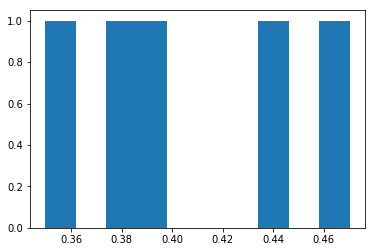

In [126]:
plt.hist(bkts[:,3])

In [117]:
food = {'pizza': 324, 'sandwich': 78, 'hot dog': 90}
food_list=list(food.values())
print(food_list)
food.values()

[324, 78, 90]


dict_values([324, 78, 90])

In [68]:
time_start = time.time()
parameters = (0.1, 0.3, 0.1, 0.12)
ssr(tp, parameters)
time_end = time.time()
print('total Running time: {}'.format(time_end - time_start), tp.shape[0])

total Running time: 0.0050351619720458984 197


In [69]:
time_start = time.time()
parameters = (0.1, 0.3, 0.1, 0.12)
ssr(df1, parameters)
time_end = time.time()
print('total Running time: {}'.format(time_end - time_start), df1.shape[0])

total Running time: 0.20855426788330078 81598


In [9]:
import numpy as np
data = np.arange(1,20)
m = np.mean(data)
v = np.var(data)
new = (data - m )/ v

print(new)
print(np.var(new),np.mean(new))

[-0.3        -0.26666667 -0.23333333 -0.2        -0.16666667 -0.13333333
 -0.1        -0.06666667 -0.03333333  0.          0.03333333  0.06666667
  0.1         0.13333333  0.16666667  0.2         0.23333333  0.26666667
  0.3       ]
0.03333333333333333 0.0


In [154]:
time_start = time.time()
my_df_ssr=[]
min_ssr=1e5

for l0 in  np.linspace(0.1, 0.5, 5):
    for trans in np.linspace(0.1, 0.5, 5):
        for guess in np.linspace(0.1, 0.5, 5):
            for slip in np.linspace(0.1, 0.5, 5):
                
                parameters=l0, trans, guess, slip
                ssr_val=ssr(my_df, *parameters)
                my_df_ssr.append(ssr_val)
                
                if ssr_val < min_ssr :
                    min_para=parameters
                    min_ssr=ssr_val
                    print(parameters, ssr_val)
                                
time_end = time.time()
print('total_grid 16', 'Running time: {}'.format(time_end - time_start))

TypeError: ssr() takes 2 positional arguments but 5 were given

In [ ]:
parameters = (0.3, 0.1, 0.5, 0.1)
ssr(my_df, *parameters)

In [ ]:
final_df=df1[['user_id', 'tag_code', 'is_right']]
std1=final_df[final_df['tag_code']=='c210111']
train, test =  train_test_split(std1, test_size=0.2)
train.shape, test.shape

In [ ]:
time_start = time.time()
test_ssr=[]
train_ssr=[]
min_ssr=1e5
i=0
l0=0.1
for trans in np.linspace(0.1, 1.0, 10):
        for guess in np.linspace(0.1, 0.5, 10):
            for slip in np.linspace(0.1, 0.5, 10):
                i+=1
                parameters=l0, trans, guess, slip
                ssr_val=ssr(train, *parameters)
                train_ssr.append(ssr_val)
                test_ssr.append(ssr(test, *parameters))
                if ssr_val < min_ssr :
                    min_para=parameters
                    min_ssr=ssr_val
                    print(i, parameters, ssr_val)
                                
time_end = time.time()
print('total_grid 16', 'Running time: {}'.format(time_end - time_start))

In [ ]:
plt.xlim(600, 640)
plt.plot(test_ssr)
plt.plot(train_ssr)

In [ ]:
# ssr(test, *(0.4, 0.0, 0.0, 0.0))

test_ssr[622]
min(test_ssr), test_ssr.index(min(test_ssr))

In [ ]:
time_start = time.time()
test_ssr=[]
train_ssr=[]
min_ssr=1e5
i=0

train, test = train_test_split(my_df, test_size=0.2)
print(my_df.shape, train.shape, test.shape)

for l0 in  np.linspace(0.1, 0.5, 5):
    for trans in np.linspace(0.1, 0.5, 5):
        for guess in np.linspace(0.1, 0.5, 5):
            for slip in np.linspace(0.1, 0.5, 5):
                i+=1
                parameters=l0, trans, guess, slip
                ssr_val=ssr(train, *parameters)
                train_ssr.append(ssr_val)
                test_ssr.append(ssr(test, *parameters))
                if ssr_val < min_ssr :
                    min_para=parameters
                    min_ssr=ssr_val
                    print(i, parameters, ssr_val)
                                
time_end = time.time()
print('total_grid 16', 'Running time: {}'.format(time_end - time_start))

In [ ]:
plt.xlim(550, 600)
plt.plot(train_ssr)
plt.plot(test_ssr)

In [ ]:
min_para, ssr(df, *min_para)

In [ ]:
parameters = (0.5, 0.9, 0.5, 0.2)
ssr(df, *parameters)

In [ ]:
ssr(df, *min_para)